# Homework 2 - IEEE Fraud Detection

In [702]:
#import all the necessary modules
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sb
import xgboost as xgb
import lightgbm as lgbm
import matplotlib.pyplot as plt
from sklearn import linear_model
from IPython.display import display
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


warnings.filterwarnings('ignore')

#path constants (change these to load dataset in your own machine)
TRANSACTION_TRAIN_CSV = "train_transaction.csv"
ID_TRAIN_CSV = "train_identity.csv"
TRANSACTION_TEST_CSV = "test_transaction.csv"
ID_TEST_CSV = "test_identity.csv"

## Part 1 - Fraudulent vs Non-Fraudulent Transaction

In [703]:
#Class to handle dataframe operations
class DataFrame_Hdl(object):
    def __init__(self, pd):
        self.pd = pd
    
    def read_from_csv(self, path):
        print("Reading Data from: " + path)
        return self.pd.read_csv(path)
    
    def write_to_csv(self,df,path):
        print("Writing Data to: " + path)
        df.to_csv(path, index = False)
    
    def merge_dataframe(self, left_df, right_df, on_field, m_type):
        print("Merging the Dataframes")
        temp_df = self.pd.merge(left_df, right_df, on=on_field, how=m_type)
        print("Dataframes Merged")
        return temp_df

In [704]:
hdl = DataFrame_Hdl(pd)

In [705]:
#read the training CSV (Transaction + ID)
trns_train_df = hdl.read_from_csv(TRANSACTION_TRAIN_CSV)
id_train_df = hdl.read_from_csv(ID_TRAIN_CSV)

Reading Data from: /Users/hardik/Desktop/CSE-519/HW2/ieee-fraud-detection/train_transaction.csv
Reading Data from: /Users/hardik/Desktop/CSE-519/HW2/ieee-fraud-detection/train_identity.csv


In [706]:
# Class with utility functions for Exploratory Data Analysis
class EDA:
    @staticmethod
    def display_df_meta(df, df_name, head_val):
        print(df_name + " Dataframe Shape:"+str(df.shape))
        df_cols = [col for col in df.columns]
        display(df.head(head_val))
    
    @staticmethod
    #Reference (to plot percentage on top of bar): https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
    def perc_set(total_list, axis_list, align):
        perc_l = lambda x,y: (x/y)*100
        for idx, ax in enumerate(axis_list):
            for p in ax.patches:
                try:
                    ax.text(p.get_x()+p.get_width()/2, p.get_height() + 10, '{:3.2f}%'.format(perc_l(p.get_height(),total_list[idx])), ha=align)
                except:
                    pass

    @staticmethod
    #Reference (to plot value on top of bar): https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
    def pheight_set(ax, adj_x=0.1, adj_y=0.1 , perc = True):
        for p in ax.patches:
            try:
                if perc:
                    ax.text(p.get_x()+p.get_width()/2+ adj_x, p.get_height()+adj_y, '{:3.2f}%'.format(p.get_height()), ha="center")
                else:
                    ax.text(p.get_x()+p.get_width()/2+ adj_x, p.get_height()+adj_y, '{:3.2f}'.format(p.get_height()), ha="center")
            except:
                pass
    
    @staticmethod
    def splitter(df, field, val1, val2):
        #Filter the fradulent transactions
        return (df.loc[df[field] == val1], df.loc[df[field] == val2])
    
    @staticmethod
    # Counting NAN values in each column
    def count_nan(df):
        display(df.isna().sum().transform(lambda x: x/len(df) * 100))
    
    @staticmethod
    def category_distrib(orig_df, category):
        pass
    
    @staticmethod
    def cal_mean_by_category(calc_df, cat1, cat2, name):
        pass


In [707]:
EDA.display_df_meta(trns_train_df, 'Transaction', 5)

Transaction Dataframe Shape:(590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [708]:
EDA.display_df_meta(id_train_df, 'Identity', 5)

Identity Dataframe Shape:(144233, 41)


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [709]:
#Merging the dataframes to create a single training dataframe
train_df = hdl.merge_dataframe(trns_train_df, id_train_df,'TransactionID','left')

Merging the Dataframes
Dataframes Merged


In [710]:
#Checking the merged dataset
EDA.display_df_meta(train_df, 'Merged Training', 5)

Merged Training Dataframe Shape:(590540, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [711]:
fraud_cnt = (train_df.isFraud == 1).sum()
valid_cnt = (train_df.isFraud == 0).sum()

In [712]:
#Calculate the number of transactions that are fraud
fraud_percent = (fraud_cnt / (fraud_cnt + valid_cnt)) * 100
print("Fraud Count:" + str(fraud_cnt))
print("Valid Count:" + str(valid_cnt))
print("Percentage of Fraudulent Transactions:"+str(fraud_percent))

Fraud Count:20663
Valid Count:569877
Percentage of Fraudulent Transactions:3.4990009144173126


In [713]:
def set_vis_metadata(axis_list, vis_label):
    for idx,ax in enumerate(axis_list):
        ax.set_title(vis_label[idx])

In [714]:
#Referenece for pie chart: https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py
def plot_pie(labels, sizes, ax):
    ax.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=False, startangle=180)
    ax.axis('equal')


In [715]:
sb.set(style="darkgrid")

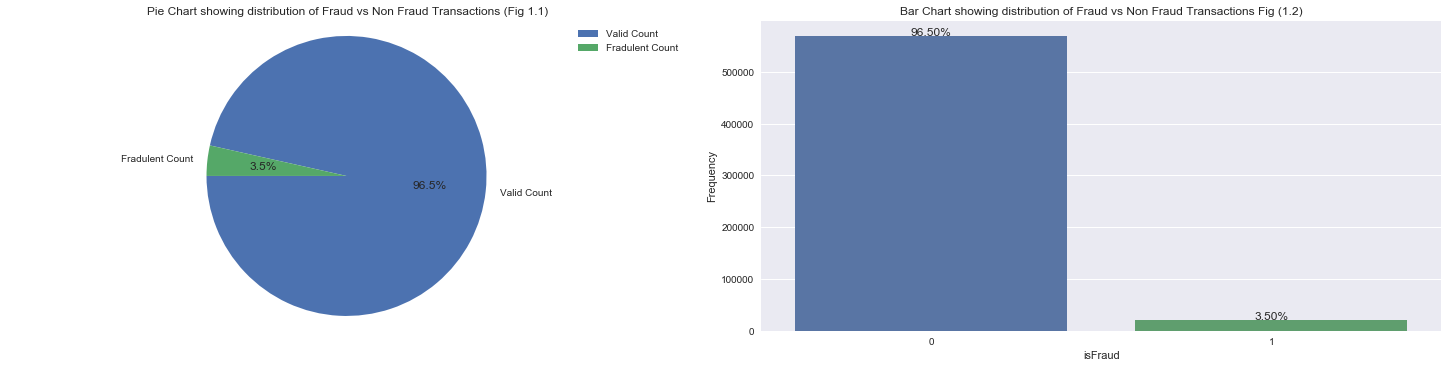

In [716]:
#Reference for multiple plots in same row: https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html
_, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5), constrained_layout=True)

dinfo_t = train_df.groupby('isFraud').size().reset_index(name='Frequency')
#ref for barplot: https://seaborn.pydata.org/generated/seaborn.barplot.html
sb.barplot(x="isFraud", y='Frequency', data=dinfo_t, ax=ax2)

EDA.perc_set([len(train_df)], [ax2], "center")
plot_pie(["Valid Count", "Fradulent Count"],[valid_cnt, fraud_cnt],ax1)

set_vis_metadata([ax1,ax2], ["Pie Chart showing distribution of Fraud vs Non Fraud Transactions (Fig 1.1)", "Bar Chart showing distribution of Fraud vs Non Fraud Transactions Fig (1.2)"])
ax1.legend()

From the basic merging of the training datasets (transaction and identity), we can observe that around 3.5% of the total transactions are fradulent i.e. isFraud == 1 for such transactions.

In [717]:
#Split the training set using isFraud feature
fraud_df, valid_df = EDA.splitter(train_df, "isFraud", 1, 0)

In [718]:
#extracting the columns needed for Part 1-5 of the assignment
required_cols = ["TransactionID", "TransactionDT", "TransactionAmt", "ProductCD", "DeviceType", "DeviceInfo",
                 "P_emaildomain", "R_emaildomain", "card4", "card6", "addr1", "addr2", "dist1", "dist2"]

fraud_df = fraud_df[required_cols]
EDA.display_df_meta(fraud_df, 'Fraud', 5)

Fraud Dataframe Shape:(20663, 14)


,TransactionID,TransactionDT,TransactionAmt,ProductCD,DeviceType,DeviceInfo,P_emaildomain,R_emaildomain,card4,card6,addr1,addr2,dist1,dist2
203,2987203,89760,445.000,W,NaN,NaN,aol.com,NaN,visa,credit,251.0,87.0,NaN,NaN
240,2987240,90193,37.098,C,mobile,Redmi Note 4 Build/MMB29M,hotmail.com,hotmail.com,visa,credit,NaN,NaN,NaN,NaN
243,2987243,90246,37.098,C,mobile,Redmi Note 4 Build/MMB29M,hotmail.com,hotmail.com,visa,credit,NaN,NaN,NaN,NaN
245,2987245,90295,37.098,C,mobile,Redmi Note 4 Build/MMB29M,hotmail.com,hotmail.com,visa,credit,NaN,NaN,NaN,NaN
288,2987288,90986,155.521,C,mobile,NaN,outlook.com,outlook.com,visa,credit,NaN,NaN,NaN,NaN


In [719]:
valid_df = valid_df[required_cols]
EDA.display_df_meta(valid_df, 'Valid', 5)

Valid Dataframe Shape:(569877, 14)


,TransactionID,TransactionDT,TransactionAmt,ProductCD,DeviceType,DeviceInfo,P_emaildomain,R_emaildomain,card4,card6,addr1,addr2,dist1,dist2
0,2987000,86400,68.5,W,NaN,NaN,NaN,NaN,discover,credit,315.0,87.0,19.0,NaN
1,2987001,86401,29.0,W,NaN,NaN,gmail.com,NaN,mastercard,credit,325.0,87.0,NaN,NaN
2,2987002,86469,59.0,W,NaN,NaN,outlook.com,NaN,visa,debit,330.0,87.0,287.0,NaN
3,2987003,86499,50.0,W,NaN,NaN,yahoo.com,NaN,mastercard,debit,476.0,87.0,NaN,NaN
4,2987004,86506,50.0,H,mobile,SAMSUNG SM-G892A Build/NRD90M,gmail.com,NaN,mastercard,credit,420.0,87.0,NaN,NaN


In [720]:
# Performing a rudimentary numerical analysis of the data and required fields for Part 1 of the assignment
def numerical_analysis(df, desc_cols, df_name):
        print ("Percentage of NAN values in the "+df_name+" dataset:")
        EDA.count_nan(df)
        print ("Data type values in the "+df_name+" dataset:")
        display(df.dtypes)
        print ("Description of "+df_name+" dataset:")
        display(df[desc_cols].describe())

In [721]:
numerical_analysis(fraud_df, ["TransactionDT", "TransactionAmt", "dist1", "dist2"], "Fraud")

Percentage of NAN values in the Fraud dataset:


TransactionID      0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
DeviceType        45.743600
DeviceInfo        58.345836
P_emaildomain     13.502396
R_emaildomain     45.666167
card4              0.198422
card6              0.188743
addr1             37.463098
addr2             37.463098
dist1             76.987853
dist2             81.943571
dtype: float64

Data type values in the Fraud dataset:


TransactionID       int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
DeviceType         object
DeviceInfo         object
P_emaildomain      object
R_emaildomain      object
card4              object
card6              object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
dtype: object

Description of Fraud dataset:


,TransactionDT,TransactionAmt,dist1,dist2
count,2.066300e+04,20663.000000,4755.000000,3731.000000
mean,7.690033e+06,149.244779,174.588854,201.472259
std,4.416551e+06,232.212163,424.232313,451.589576
min,8.976000e+04,0.292000,0.000000,0.000000
25%,3.965858e+06,35.044000,3.000000,7.000000
50%,7.575230e+06,75.000000,10.000000,49.000000
75%,1.121743e+07,161.000000,85.500000,233.000000
max,1.581088e+07,5191.000000,4942.000000,9337.000000


In [722]:
numerical_analysis(valid_df, ["TransactionDT", "TransactionAmt", "dist1", "dist2"], "Valid")

Percentage of NAN values in the Valid dataset:


TransactionID      0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
DeviceType        77.258426
DeviceInfo        80.687236
P_emaildomain     16.085225
R_emaildomain     77.878735
card4              0.269532
card6              0.268830
addr1             10.171493
addr2             10.171493
dist1             59.023789
dist2             94.052050
dtype: float64

Data type values in the Valid dataset:


TransactionID       int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
DeviceType         object
DeviceInfo         object
P_emaildomain      object
R_emaildomain      object
card4              object
card6              object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
dtype: object

Description of Valid dataset:


,TransactionDT,TransactionAmt,dist1,dist2
count,5.698770e+05,569877.000000,233514.000000,33896.000000
mean,7.360791e+06,134.511665,117.360098,235.199758
std,4.623930e+06,239.395078,370.641879,536.798492
min,8.640000e+04,0.251000,0.000000,0.000000
25%,3.010651e+06,43.970000,3.000000,7.000000
50%,7.271678e+06,68.500000,8.000000,36.000000
75%,1.125334e+07,120.000000,24.000000,206.000000
max,1.581113e+07,31937.391000,10286.000000,11623.000000


- Basic Numerical analysis show that there in columns like dist1 and dist2 there are more than 80% Nan values, so these columns might not be as helpful in final analysis and predictions
- Another interesting thing to observe is that TransactionAmt has similar mean and standard deviation for Fraud and Valid transactions, so the distribution in both cases will be somewhat similar

In [723]:
def dist_plotter(axis_list, title_list, case, field, kd, color_p):
    #Reference for distplot: https://seaborn.pydata.org/tutorial/distributions.html
    sb.distplot(fraud_df[field], kde=kd, bins=20, ax = axis_list[0], color=color_p[0]).set_title(title_list[0])
    sb.distplot(valid_df[field], kde=kd, bins=20, ax = axis_list[1], color=color_p[1]).set_title(title_list[1])
    
    if case == 1:
        sb.distplot(fraud_df[field], kde = kd, bins=20, ax = axis_list[2], color=color_p[0], label = "Fraud Transactions")
        sb.distplot(valid_df[field], kde = kd, bins=20, ax = axis_list[2], color=color_p[1], label = "Valid Transactions").set_title(title_list[2])
        axis_list[2].legend()


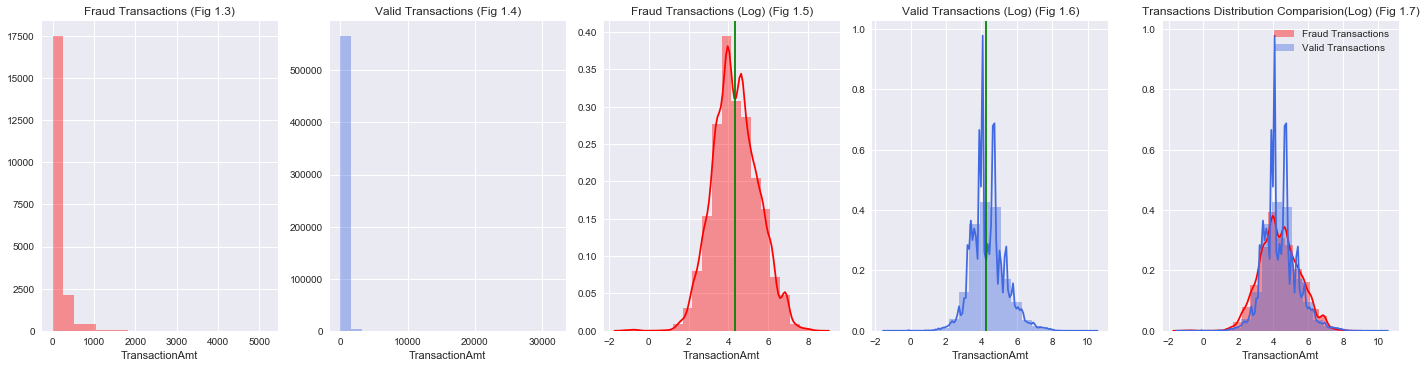

In [724]:
#Plotting TransactionAmt
_, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(20, 5), constrained_layout=True)

valid_median=valid_df['TransactionAmt'].transform(lambda x: np.log(x)).median()
fraud_median=fraud_df['TransactionAmt'].transform(lambda x: np.log(x)).median()

dist_plotter([ax1,ax2], ["Fraud Transactions (Fig 1.3)", "Valid Transactions (Fig 1.4)"], 0, 'TransactionAmt', False, ["r", "royalblue"])

#Reference for taking a log of a pandas series (last example): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.apply.html
sb.distplot(fraud_df['TransactionAmt'].transform(lambda x: np.log(x)), bins=20, ax = ax3, color="r").set_title("Fraud Transactions (Log) (Fig 1.5)")
sb.distplot(valid_df['TransactionAmt'].transform(lambda x: np.log(x)), bins=20, ax = ax4, color="royalblue").set_title("Valid Transactions (Log) (Fig 1.6)")

sb.distplot(fraud_df['TransactionAmt'].transform(lambda x: np.log(x)), bins=20, ax = ax5, color="r", label="Fraud Transactions")
sb.distplot(valid_df['TransactionAmt'].transform(lambda x: np.log(x)), bins=20, ax = ax5, color="royalblue", label="Valid Transactions").set_title("Transactions Distribution Comparision(Log) (Fig 1.7)")

ax5.legend()
#Plotting the median in Fig 1.5 and Fig 1.6
ax3.axvline(fraud_median, color='g', linestyle='-')
ax4.axvline(valid_median, color='g', linestyle='-')

plt.show()

- The first two figures from the left (Fig 1.3 and Fig 1.4) are the distribution plots of TransactionAmt field in fraud and Valid Transactions. These distributions exhibit Power Law i.e. small no of bins in the top have maximum data.
- Then I have displayed a log distribution to analyze the Transaction Amt properly for Fraud and Valid Transactions both in Fig 1.5 and Fig 1.6 respectively. The green line in the middle is the distribution median. If you notice the distribution is almost similar but for fraud transactions the mean is higher and distribution is sharper. (Green Line is the median)
- In Fig 1.7, I have compared the two distributions by superimposing them.

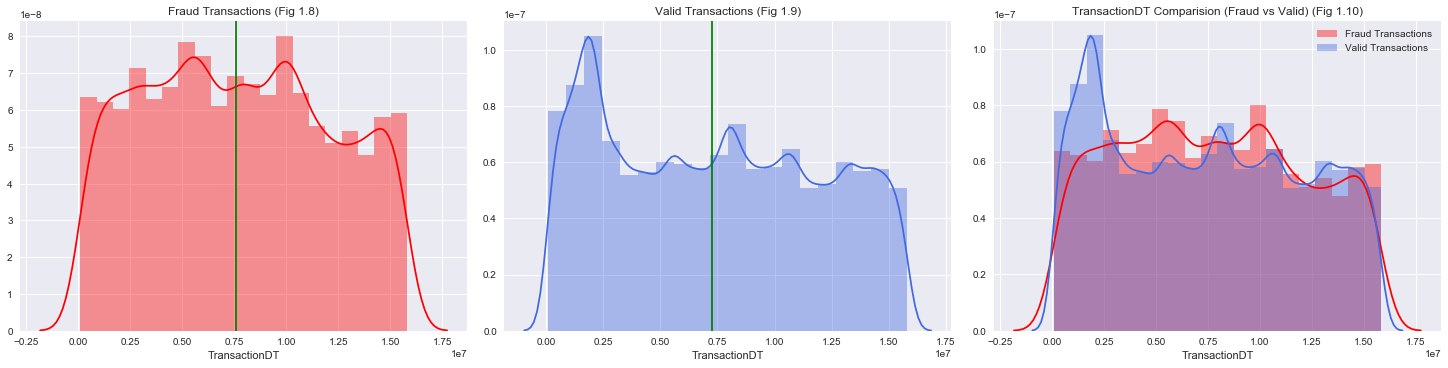

In [725]:
#Plotting TransactionDT
_, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 5), constrained_layout=True)

#Plotting the median in Fig 1.8 and Fig 1.9
valid_median=valid_df['TransactionDT'].median()
fraud_median=fraud_df['TransactionDT'].median()

dist_plotter([ax1,ax2,ax3], ["Fraud Transactions (Fig 1.8)", "Valid Transactions (Fig 1.9)", "TransactionDT Comparision (Fraud vs Valid) (Fig 1.10)"], 1, 'TransactionDT', True, ["r", "royalblue"])
ax1.axvline(fraud_median, color='g', linestyle='-')
ax2.axvline(valid_median, color='g', linestyle='-')

plt.show()

- Fig 1.8 and Fig 1.9 display the TransactionDT distribution plot for Fraud and Valid Transactions. (Green Line is the median)
- Fig 1.10 is the comparison of TransactionDT for Fraud and Valid transactions by superimposition

In [726]:
fraud_plt_dict = {0:"royalblue", 1:"r"}

In [727]:
def pd_category_distrib(orig_df, category):
    prod_distrib = (orig_df[['isFraud',category]].groupby(['isFraud', category]).size().reset_index(name='value_count'))
    #Ref calc percentage: https://stackoverflow.com/questions/21206401/pandas-percentage-within-category
    prod_distrib['perc_distrib'] = prod_distrib.groupby('isFraud')['value_count'].transform(lambda x: np.true_divide(x, np.sum(x))*100)
    return prod_distrib

In [728]:
EDA.category_distrib = pd_category_distrib

In [729]:
# Preliminary analysis of the numerical data for each category of ProductCD for both Valid and Fraud Transactions
display(EDA.category_distrib(train_df, 'ProductCD'))

,isFraud,ProductCD,value_count,perc_distrib
0,0,C,60511,10.618256
1,0,H,31450,5.518735
2,0,R,36273,6.365058
3,0,S,10942,1.920063
4,0,W,430701,75.577888
5,1,C,8008,38.755263
6,1,H,1574,7.617481
7,1,R,1426,6.901224
8,1,S,686,3.319944
9,1,W,8969,43.406088


- Category distribution of ProductCD

In [730]:
cat_dev = EDA.category_distrib(train_df, "ProductCD")
f_cat_dev,v_cat_dev = EDA.splitter(cat_dev, "isFraud", 1, 0)

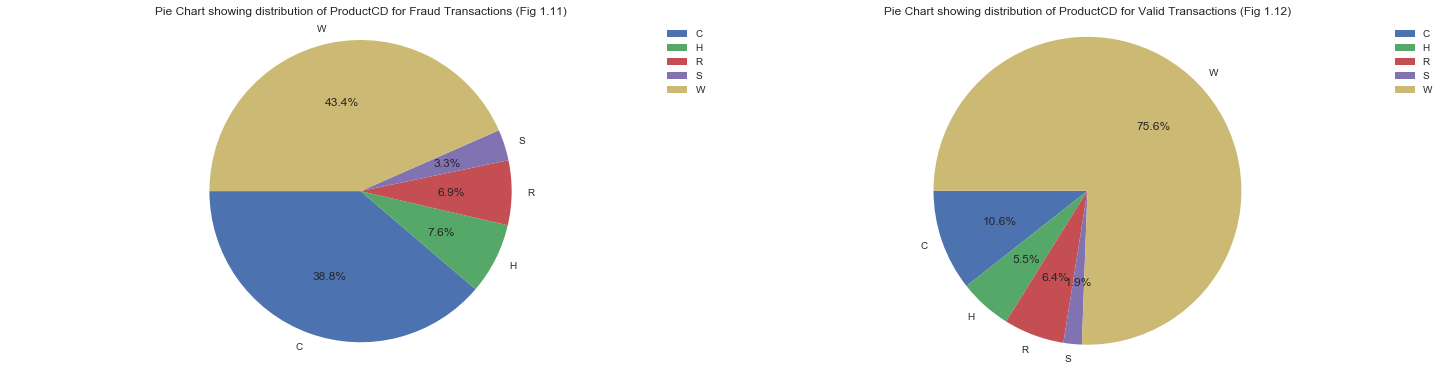

In [731]:
#Plot category distribution of ProductCD
_, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5), constrained_layout=True)
plot_pie(f_cat_dev['ProductCD'].tolist(), f_cat_dev['perc_distrib'].tolist(),ax1)
plot_pie(v_cat_dev['ProductCD'].tolist(), v_cat_dev['perc_distrib'].tolist(),ax2)
set_vis_metadata([ax1,ax2], ["Pie Chart showing distribution of ProductCD for Fraud Transactions (Fig 1.11)", "Pie Chart showing distribution of ProductCD for Valid Transactions (Fig 1.12)"])
ax1.legend()
ax2.legend()

In [732]:
def vis_gen(field, title_list, axis_list, palette, cmp_pal, ph=True, color=False):
    #Ref for countplot: https://seaborn.pydata.org/generated/seaborn.countplot.html#seaborn.countplot
    sb.countplot(x=field, data=fraud_df, ax=axis_list[0], palette=palette).set_title(title_list[0])
    sb.countplot(x=field, data=valid_df, ax=axis_list[1], palette=palette).set_title(title_list[1])
    prod_distrib = EDA.category_distrib(train_df, field)
    
    #Reference for barplot: https://seaborn.pydata.org/generated/seaborn.barplot.html
    sb.barplot(x=field, y='perc_distrib', hue='isFraud', data=prod_distrib, ax=axis_list[2], palette=cmp_pal)

    fraud_t = fraud_df[field].value_counts().sum()
    valid_t = valid_df[field].value_counts().sum()
    EDA.perc_set([fraud_t, valid_t], axis_list[:-1], "center")
    if ph:
        EDA.pheight_set(axis_list[-1], adj_x=0)

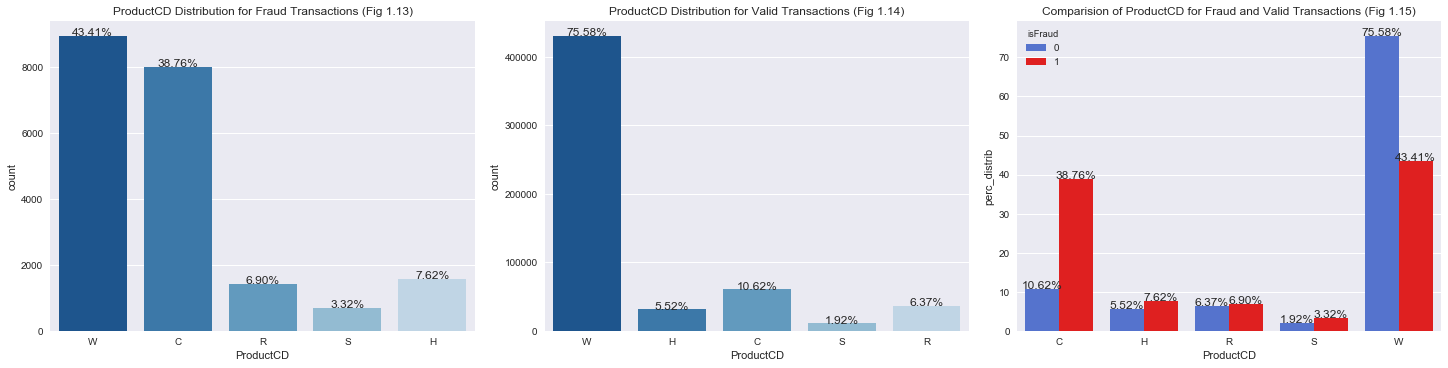

In [733]:
_, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 5), constrained_layout=True)
vis_gen('ProductCD', ["ProductCD Distribution for Fraud Transactions (Fig 1.13)", "ProductCD Distribution for Valid Transactions (Fig 1.14)"],[ax1, ax2, ax3], sb.color_palette("Blues_r"), ["royalblue", "r"])
set_vis_metadata([ax3], ["Comparision of ProductCD for Fraud and Valid Transactions (Fig 1.15)"])

- Fig 1.13 and Fig 1.14 represent the categorical frequency of ProductCD for Fraud and Valid Transactions respectively.
- Fig 1.15 compares the percentage of each category of ProductCD for Fraud and Valid Transactions.
- Some interesting things to notice are that Product C is more popular in Fraudulent transaction as compared to Valid Transaction and vice versa in  case of  Product W.

In [734]:
def plot_dist_vis(field, title_list):
    _, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20, 5), constrained_layout=True)

    sb.distplot(fraud_df[field].dropna(), kde=False, bins=10,ax = ax1, color="r").set_title(title_list[0])
    sb.distplot(valid_df[field].dropna(), kde=False, bins=10, ax = ax2).set_title(title_list[1])

    #Reference for kdeplot: https://seaborn.pydata.org/generated/seaborn.kdeplot.html
    sb.kdeplot(fraud_df[field].dropna(),ax = ax3, color="r").set_title(title_list[2])
    sb.kdeplot(valid_df[field].dropna(), ax = ax4).set_title(title_list[3])
    valid_median=valid_df[field].median()
    fraud_median=fraud_df[field].median()

    ax3.axvline(fraud_median, color='g', linestyle='-')
    ax4.axvline(valid_median, color='g', linestyle='-')

Dist1 field has: 59.6523520845328% values as nan


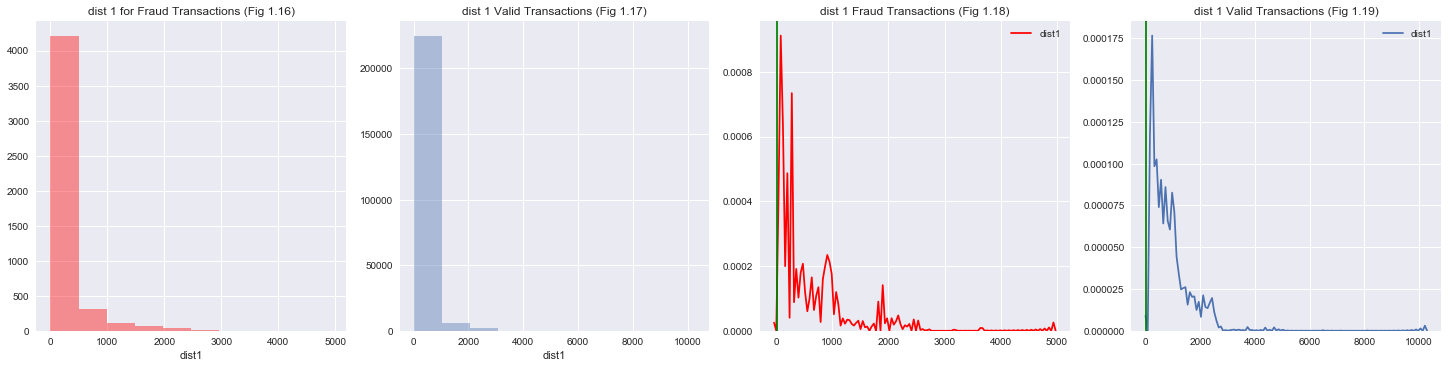

In [735]:
#Distribution for dist1
dist_nan_per = train_df["dist1"].isna().sum()/len(train_df)*100
print("Dist1 field has: "+str(dist_nan_per)+"% values as nan")
plot_dist_vis("dist1", ["dist 1 for Fraud Transactions (Fig 1.16)", "dist 1 Valid Transactions (Fig 1.17)", "dist 1 Fraud Transactions (Fig 1.18)", "dist 1 Valid Transactions (Fig 1.19)"])


Dist2 field has: 93.62837403054831% values as nan


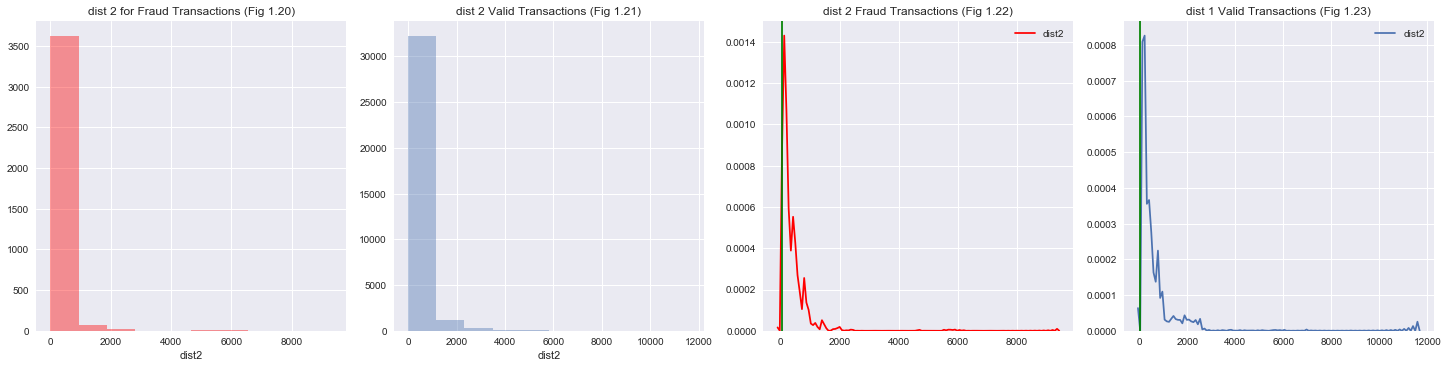

In [736]:
#Distribution for dist2
dist_nan_per = train_df["dist2"].isna().sum()/len(train_df)*100
print("Dist2 field has: "+str(dist_nan_per)+"% values as nan")
plot_dist_vis("dist2", ["dist 2 for Fraud Transactions (Fig 1.20)", "dist 2 Valid Transactions (Fig 1.21)", "dist 2 Fraud Transactions (Fig 1.22)", "dist 1 Valid Transactions (Fig 1.23)"])

- The entries for dist1 and dist2 are very sparse with more than 80% entries as Nan for dist2 and more than 50% values as Nan for dist1.
- In the above Figures the sparsity of the values is evident.

In [737]:
# Preliminary analysis of the numerical data for each category of ProductCD for both Valid and Fraud Transactions
display(EDA.category_distrib(train_df, 'DeviceType'))

,isFraud,DeviceType,value_count,perc_distrib
0,0,desktop,79611,61.428715
1,0,mobile,49988,38.571285
2,1,desktop,5554,49.540630
3,1,mobile,5657,50.459370


- Category Distribution for Device Type

In [738]:
cat_dev = EDA.category_distrib(train_df, "DeviceType")
f_cat_dev,v_cat_dev = EDA.splitter(cat_dev, "isFraud", 1, 0)

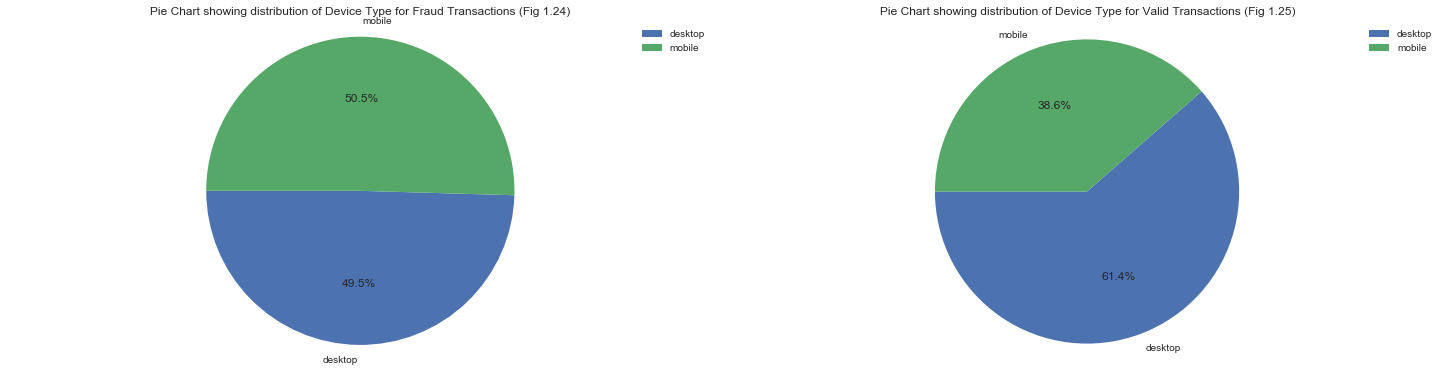

In [739]:
#Plotting Category Distribution for Device Type
_, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5), constrained_layout=True)
plot_pie(f_cat_dev['DeviceType'].tolist(), f_cat_dev['perc_distrib'].tolist(),ax1)
plot_pie(v_cat_dev['DeviceType'].tolist(), v_cat_dev['perc_distrib'].tolist(),ax2)
set_vis_metadata([ax1,ax2], ["Pie Chart showing distribution of Device Type for Fraud Transactions (Fig 1.24)", "Pie Chart showing distribution of Device Type for Valid Transactions (Fig 1.25)"])
ax1.legend()
ax2.legend()

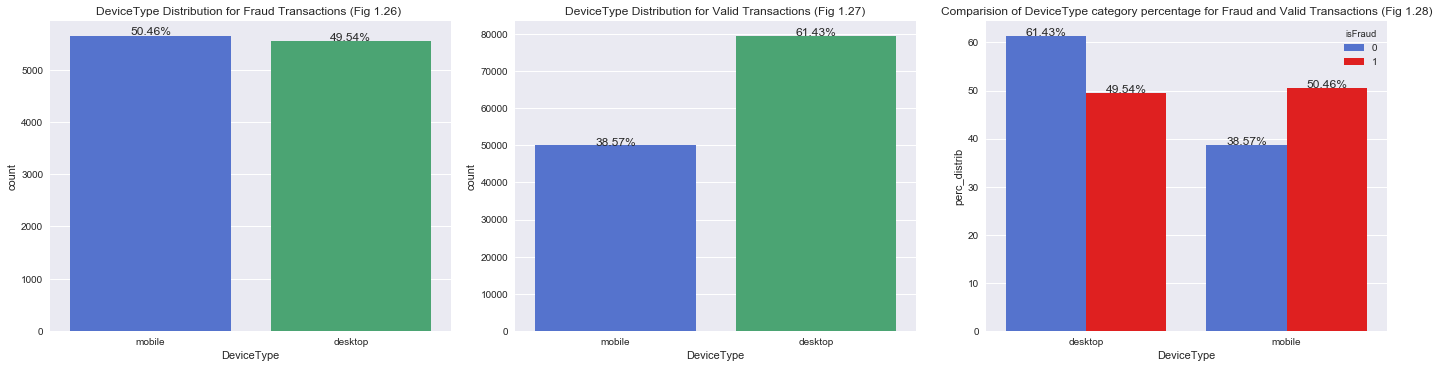

In [740]:
_, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 5), constrained_layout=True)
vis_gen('DeviceType', ["DeviceType Distribution for Fraud Transactions (Fig 1.26) ", "DeviceType Distribution for Valid Transactions (Fig 1.27)"],[ax1, ax2, ax3],['royalblue', 'mediumseagreen'], ["royalblue","r"])
set_vis_metadata([ax3], ["Comparision of DeviceType category percentage for Fraud and Valid Transactions (Fig 1.28)"])

- From Fig 1.26, 1.27 and 1.28 it is evident that mobile devices are used more for the Fraudulent transactions, while people engaing in Valid transactions tend to prefer Desktop machines. This can be an interesting feature for predicting fraud transactions.

In [741]:
def plot_bar(df, axis, field, top, title = "", hor=True):
    dinfo_t = df.groupby(field).size().reset_index(name='freq')
    dinfo_t = dinfo_t.nlargest(top, 'freq')
    if hor:
        #Ref for bar plot: https://seaborn.pydata.org/generated/seaborn.barplot.html
        sb.barplot(x="freq", y=field, data=dinfo_t, ax=axis, palette=sb.color_palette("Blues_r", top))
    else:
        sb.barplot(x=field, y="freq", data=dinfo_t, ax=axis, palette=sb.color_palette("Blues_r", top))
    
    axis.set_title(title)
    del dinfo_t    


In [742]:
print("No of Unique Values in Device Info: "+str(len(train_df.groupby('DeviceInfo').size())))

No of Unique Values in Device Info: 1786


In [743]:
dev_cat = EDA.category_distrib(train_df, 'DeviceInfo')
display(dev_cat)

,isFraud,DeviceInfo,value_count,perc_distrib
0,0,0PAJ5,1,0.000909
1,0,0PJA2,1,0.000909
2,0,0PM92,2,0.001817
3,0,1016S,1,0.000909
4,0,2PQ93,1,0.000909
5,0,2PS64 Build/NRD90M,6,0.005452
6,0,2PYB2,4,0.003634
7,0,2PZC5,2,0.001817
8,0,4003A,1,0.000909
9,0,4009F,2,0.001817


- Category Distribution for Device Info

In [744]:
EDA.display_df_meta(dev_cat.nlargest(20, 'perc_distrib'), "Top 20 Device Info", 20)

Top 20 Device Info Dataframe Shape:(20, 4)


,isFraud,DeviceInfo,value_count,perc_distrib
1565,0,Windows,44601,40.524628
2100,1,Windows,3121,36.261183
1684,0,iOS Device,18542,16.847327
2138,1,iOS Device,1240,14.406878
712,0,MacOS,12295,11.171281
1520,0,Trident/7.0,7344,6.672785
1888,1,MacOS,278,3.229929
2137,1,hi6210sft Build/MRA58K,180,2.091321
1994,1,SM-A300H Build/LRX22G,169,1.963518
1699,0,rv:11.0,1825,1.658202


In [745]:
display(dev_cat.nlargest(3,'perc_distrib'))

,isFraud,DeviceInfo,value_count,perc_distrib
1565,0,Windows,44601,40.524628
2100,1,Windows,3121,36.261183
1684,0,iOS Device,18542,16.847327


In [746]:
f_dev_cat, v_dev_cat = EDA.splitter(dev_cat, "isFraud", 1, 0)

In [747]:
display(f_dev_cat.nlargest(3,'perc_distrib'))

,isFraud,DeviceInfo,value_count,perc_distrib
2100,1,Windows,3121,36.261183
2138,1,iOS Device,1240,14.406878
1888,1,MacOS,278,3.229929


- Category Distribution for Device Info for Fraud Transactions

In [748]:
display(v_dev_cat.nlargest(3,'perc_distrib'))

,isFraud,DeviceInfo,value_count,perc_distrib
1565,0,Windows,44601,40.524628
1684,0,iOS Device,18542,16.847327
712,0,MacOS,12295,11.171281


- Category Distribution for Device Info for Valid Transactions

In [749]:
dev_cat = pd.concat([f_dev_cat.nlargest(3,'perc_distrib'), v_dev_cat.nlargest(3,'perc_distrib')])

In [750]:
display(dev_cat)

,isFraud,DeviceInfo,value_count,perc_distrib
2100,1,Windows,3121,36.261183
2138,1,iOS Device,1240,14.406878
1888,1,MacOS,278,3.229929
1565,0,Windows,44601,40.524628
1684,0,iOS Device,18542,16.847327
712,0,MacOS,12295,11.171281


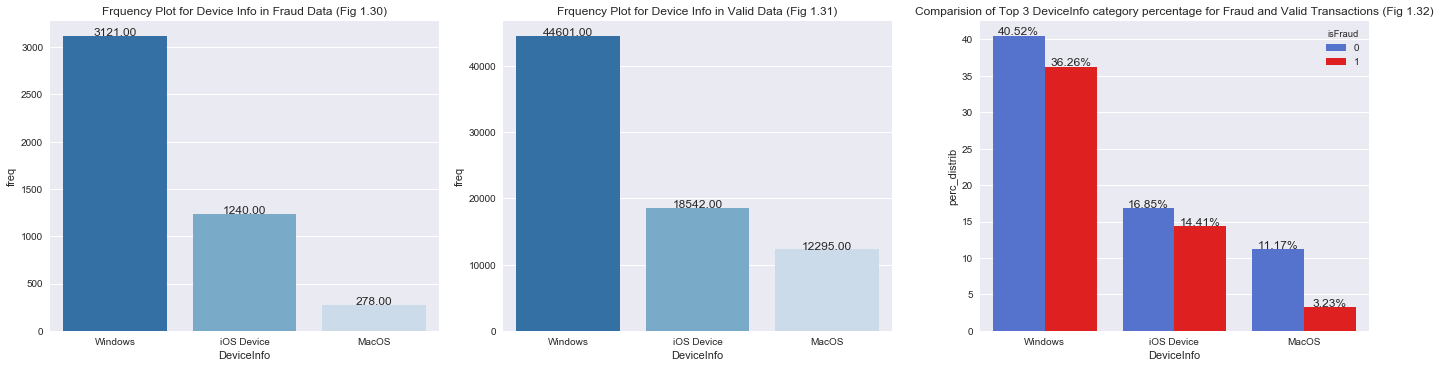

In [751]:
# Plotting Category Distribution for Device Info
_, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 5), constrained_layout=True)

plot_bar(fraud_df, ax1, 'DeviceInfo', 3, "Frquency Plot for Device Info in Fraud Data (Fig 1.30)",False)
plot_bar(valid_df, ax2, 'DeviceInfo', 3,  "Frquency Plot for Device Info in Valid Data (Fig 1.31)", False)
sb.barplot(x='DeviceInfo',y='perc_distrib', hue='isFraud', data=dev_cat, ax=ax3, palette=fraud_plt_dict)
set_vis_metadata([ax3], ["Comparision of Top 3 DeviceInfo category percentage for Fraud and Valid Transactions (Fig 1.32)"])
EDA.pheight_set(ax1, adj_x = 0, perc = False)
EDA.pheight_set(ax2, adj_x = 0, perc = False)
EDA.pheight_set(ax3, adj_x = 0)

- According to the calculations the Device Info field has 1786 unique categories regarding the make and model of devices used for fraudulent transactions.
- Horizontal plots show top 3 device info sorted via frequency used for Fraud (Fig 1.30) and Valid (Fig 1.31) transactions.
- In both cases IOS devices, Windows and MacOS are the top 3 categories.

In [752]:
def plot_addr(addr, top, title_list, rot_angle = 35):
    _, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5), constrained_layout=True)
    fraud_t = fraud_df[addr].value_counts().sum()
    valid_t = valid_df[addr].value_counts().sum()
    #reference for rotating x labels: https://stackoverflow.com/questions/43152502/how-can-i-rotate-xticklabels-in-matplotlib-so-that-the-spacing-between-each-xtic
    plot_bar(fraud_df, ax1, addr, top, title_list[0], False)
    plt.setp(ax1.get_xticklabels(), rotation=rot_angle)

    plot_bar(valid_df, ax2, addr, top, title_list[1],False)
    plt.setp(ax2.get_xticklabels(), rotation=rot_angle)
    EDA.perc_set([fraud_t, valid_t], [ax1, ax2], "center")

In [753]:
def check_addr(type):
    prod_distrib = EDA.category_distrib(train_df,type)
    display(prod_distrib.loc[prod_distrib['isFraud'] == 1].nlargest(10, 'perc_distrib'))
    display(prod_distrib.loc[prod_distrib['isFraud'] == 0].nlargest(10, 'perc_distrib'))

,isFraud,addr1,value_count,perc_distrib
352,1,204.0,1120,8.667389
375,1,325.0,1087,8.412011
369,1,299.0,985,7.622659
377,1,330.0,840,6.500542
364,1,264.0,728,5.633803
366,1,272.0,576,4.457514
396,1,441.0,533,4.124748
378,1,337.0,439,3.397307
373,1,315.0,411,3.180622
334,1,123.0,398,3.080019


,isFraud,addr1,value_count,perc_distrib
151,0,299.0,45350,8.858945
173,0,325.0,41664,8.138899
78,0,204.0,40900,7.989654
127,0,264.0,39142,7.646236
178,0,330.0,25447,4.970972
166,0,315.0,22667,4.427909
255,0,441.0,20294,3.964353
132,0,272.0,19565,3.821946
14,0,123.0,15707,3.068301
62,0,184.0,14954,2.921205


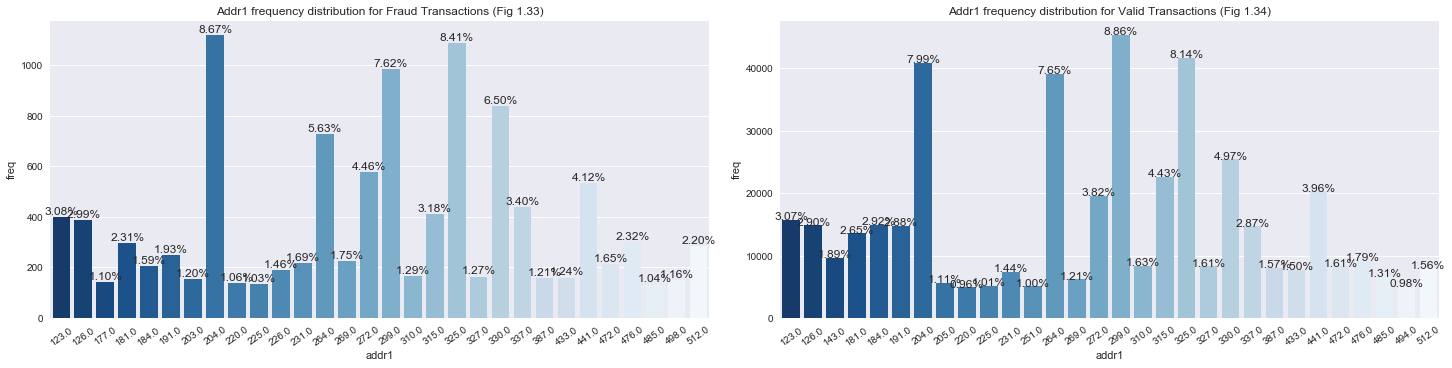

In [754]:
check_addr('addr1')
plot_addr('addr1', 30, ["Addr1 frequency distribution for Fraud Transactions (Fig 1.33)", "Addr1 frequency distribution for Valid Transactions (Fig 1.34)"])

- Distribution for addr1

,isFraud,addr2,value_count,perc_distrib
82,1,87.0,12477,96.556261
76,1,60.0,279,2.159108
84,1,96.0,89,0.688748
77,1,65.0,44,0.340505
68,1,10.0,8,0.061910
70,1,32.0,6,0.046432
74,1,51.0,4,0.030955
73,1,46.0,3,0.023216
72,1,38.0,2,0.015477
75,1,54.0,2,0.015477


,isFraud,addr2,value_count,perc_distrib
57,0,87.0,508004,99.236588
37,0,60.0,2805,0.547946
62,0,96.0,549,0.107245
19,0,32.0,85,0.016604
3,0,16.0,55,0.010744
18,0,31.0,47,0.009181
41,0,65.0,38,0.007423
6,0,19.0,33,0.006446
13,0,26.0,25,0.004884
14,0,27.0,20,0.003907


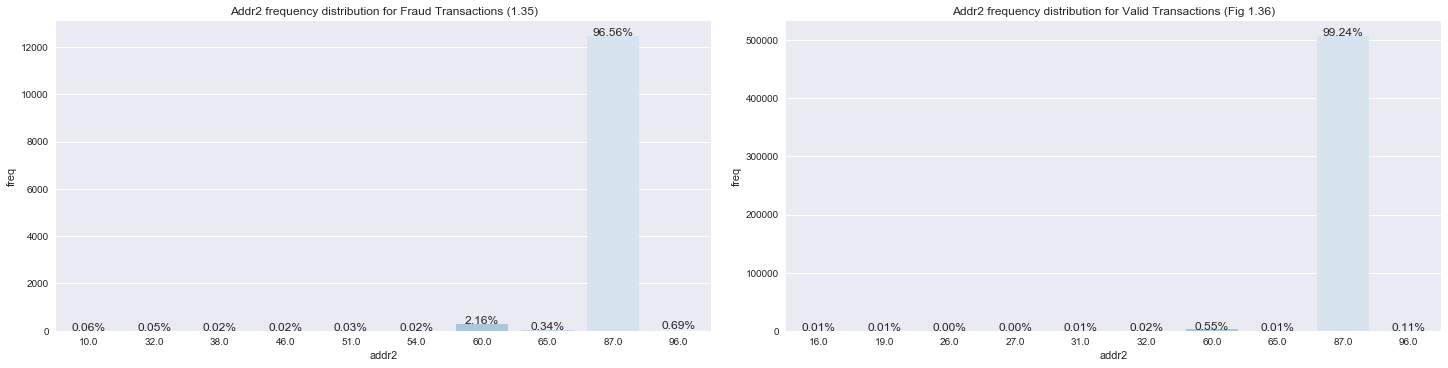

In [755]:
check_addr('addr2')
plot_addr('addr2', 10, ["Addr2 frequency distribution for Fraud Transactions (1.35)", "Addr2 frequency distribution for Valid Transactions (Fig 1.36)"], rot_angle=0)

- Distribution for addr2

- As evident from the Figures presented above and the numerical analysis the maximum entries in the training set are for addr2=87.0 (more than 95%) for both Fraud and Valid transactions.

In [756]:
print("No of Unique Values in Purchaser Email Domain: "+str(len(train_df.groupby('P_emaildomain').size())))

No of Unique Values in Purchaser Email Domain: 59


In [757]:
p_dmn = EDA.category_distrib(train_df, 'P_emaildomain')
display(p_dmn)

,isFraud,P_emaildomain,value_count,perc_distrib
0,0,aim.com,275,0.057506
1,0,anonymous.com,36139,7.557124
2,0,aol.com,27672,5.786567
3,0,att.net,4003,0.837078
4,0,bellsouth.net,1856,0.388113
5,0,cableone.net,156,0.032622
6,0,centurylink.net,205,0.042868
7,0,cfl.rr.com,172,0.035967
8,0,charter.net,791,0.165408
9,0,comcast.net,7642,1.598039


In [758]:
EDA.display_df_meta(p_dmn.nlargest(10, 'perc_distrib'), "Top 10 Purchase Email Domain" , 10)

Top 10 Purchase Email Domain Dataframe Shape:(10, 4)


,isFraud,P_emaildomain,value_count,perc_distrib
73,1,gmail.com,9943,55.631399
16,0,gmail.com,218412,45.672726
53,0,yahoo.com,98637,20.626251
74,1,hotmail.com,2396,13.405696
96,1,yahoo.com,2297,12.851788
19,0,hotmail.com,42854,8.961316
1,0,anonymous.com,36139,7.557124
2,0,aol.com,27672,5.786567
60,1,anonymous.com,859,4.806132
61,1,aol.com,617,3.452135


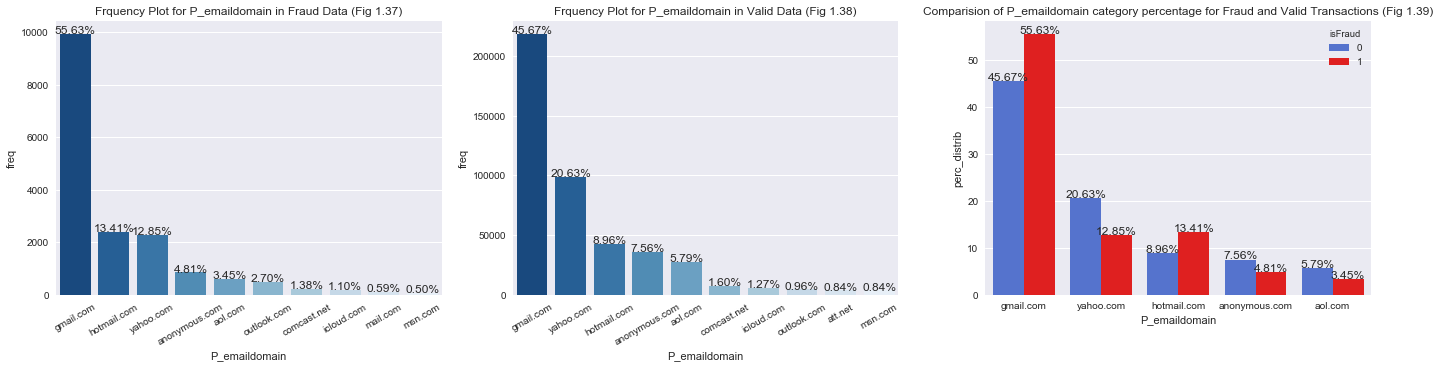

In [759]:
_, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 5), constrained_layout=True)

fraud_t = fraud_df['P_emaildomain'].value_counts().sum()
valid_t = valid_df['P_emaildomain'].value_counts().sum()

plot_bar(fraud_df, ax1, 'P_emaildomain', 10, "Frquency Plot for P_emaildomain in Fraud Data (Fig 1.37)", False)
#reference for rotating x labels: https://stackoverflow.com/questions/43152502/how-can-i-rotate-xticklabels-in-matplotlib-so-that-the-spacing-between-each-xtic
plt.setp(ax1.get_xticklabels(), rotation=30)

plot_bar(valid_df, ax2, 'P_emaildomain', 10, "Frquency Plot for P_emaildomain in Valid Data (Fig 1.38)", False)
plt.setp(ax2.get_xticklabels(), rotation=30)

prod_distrib = EDA.category_distrib(train_df, "P_emaildomain")

#Ref for barplot: https://seaborn.pydata.org/generated/seaborn.barplot.html
sb.barplot(x='P_emaildomain',y='perc_distrib', hue='isFraud', data=prod_distrib.nlargest(10, 'perc_distrib'), ax=ax3, palette=fraud_plt_dict)
plt.setp(ax3.get_xticklabels(), rotation=0)

EDA.perc_set([fraud_t, valid_t], [ax1, ax2], "center")
EDA.pheight_set(ax3,adj_x=0)
set_vis_metadata([ax3], ["Comparision of P_emaildomain category percentage for Fraud and Valid Transactions (Fig 1.39)"])

- Fig 1.37 and Fig 1.38 display the frequencies of top 10 most frequent email domains used for Purchaser email ID for Fraud and Valid data respectively.
- Fig 1.39 shows the categorical percentage comparision for top 5 domains in Fraud and Valid categories.
- In both cases Gmail is the most used email domain, however, if you observer that in case of Valid data the second most used domain is yahoo.com and in case of Fraud data it is hotmail.com

In [760]:
print("No of Unique Values in Recepient Email Domain: "+str(len(train_df.groupby('R_emaildomain').size())))

No of Unique Values in Recepient Email Domain: 60


In [761]:
r_dmn = EDA.category_distrib(train_df, 'R_emaildomain')
display(r_dmn)

,isFraud,R_emaildomain,value_count,perc_distrib
0,0,aim.com,35,0.027764
1,0,anonymous.com,19931,15.810223
2,0,aol.com,3572,2.833481
3,0,att.net,430,0.341097
4,0,bellsouth.net,420,0.333164
5,0,cableone.net,27,0.021418
6,0,centurylink.net,12,0.009519
7,0,cfl.rr.com,37,0.029350
8,0,charter.net,122,0.096776
9,0,comcast.net,1791,1.420707


In [762]:
EDA.display_df_meta(r_dmn.nlargest(10, 'perc_distrib'), "Top 10 Recepient Email Domain" , 10)

Top 10 Recepient Email Domain Dataframe Shape:(10, 4)


,isFraud,R_emaildomain,value_count,perc_distrib
68,1,gmail.com,6811,60.666251
16,0,gmail.com,50336,39.928925
19,0,hotmail.com,25369,20.123905
69,1,hotmail.com,2140,19.061192
1,0,anonymous.com,19931,15.810223
54,0,yahoo.com,11232,8.909760
87,1,yahoo.com,610,5.433330
61,1,anonymous.com,598,5.326445
80,1,outlook.com,414,3.687539
2,0,aol.com,3572,2.833481


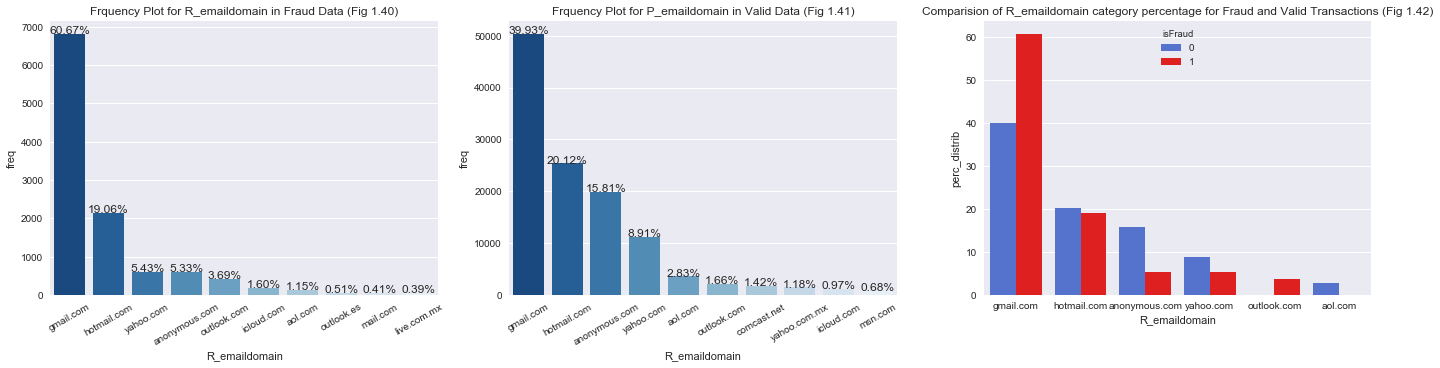

In [763]:
_, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 5), constrained_layout=True)

fraud_t = fraud_df['R_emaildomain'].value_counts().sum()
valid_t = valid_df['R_emaildomain'].value_counts().sum()

plot_bar(fraud_df, ax1, 'R_emaildomain', 10, "Frquency Plot for R_emaildomain in Fraud Data (Fig 1.40)", False)
plt.setp(ax1.get_xticklabels(), rotation=30)

plot_bar(valid_df, ax2, 'R_emaildomain', 10, "Frquency Plot for P_emaildomain in Valid Data (Fig 1.41)", False)
plt.setp(ax2.get_xticklabels(), rotation=30)

prod_distrib = EDA.category_distrib(train_df, "R_emaildomain")

#ref for barplot: https://seaborn.pydata.org/generated/seaborn.barplot.html
sb.barplot(x='R_emaildomain',y='perc_distrib', hue='isFraud', data=prod_distrib.nlargest(10, 'perc_distrib'), ax=ax3, palette=fraud_plt_dict)
plt.setp(ax3.get_xticklabels(), rotation=0)

EDA.perc_set([fraud_t, valid_t], [ax1, ax2], "center")
set_vis_metadata([ax3], ["Comparision of R_emaildomain category percentage for Fraud and Valid Transactions (Fig 1.42)"])

- Fig 1.40 and Fig 1.41 display the frequencies of top 10 most frequent email domains used for Recepient email ID for Fraud and Valid data respectively.
- Fig 1.42 shows the categorical percentage comparision for top 5 domains in Fraud and Valid categories.
- This distribution is almost similar as the one for P_emaildomain, in this scenario also the Gmail is the maximum used email domain.

In [764]:
display(EDA.category_distrib(train_df, 'card4'))

,isFraud,card4,value_count,perc_distrib
0,0,american express,8089,1.423265
1,0,discover,6137,1.079809
2,0,mastercard,182721,32.149889
3,0,visa,371394,65.347036
4,1,american express,239,1.158956
5,1,discover,514,2.492484
6,1,mastercard,6496,31.500339
7,1,visa,13373,64.848220


- Distribution for card4

In [765]:
cat_dev = EDA.category_distrib(train_df, "card4")
f_cat_dev,v_cat_dev = EDA.splitter(cat_dev, "isFraud", 1, 0)

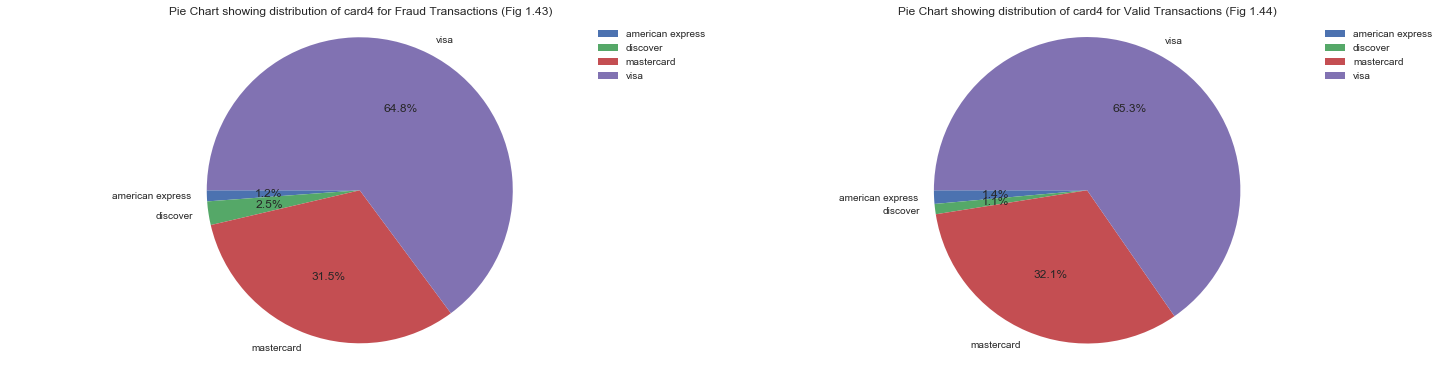

In [766]:
_, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5), constrained_layout=True)
plot_pie(f_cat_dev['card4'].tolist(), f_cat_dev['perc_distrib'].tolist(),ax1)
plot_pie(v_cat_dev['card4'].tolist(), v_cat_dev['perc_distrib'].tolist(),ax2)

set_vis_metadata([ax1,ax2], ["Pie Chart showing distribution of card4 for Fraud Transactions (Fig 1.43)", "Pie Chart showing distribution of card4 for Valid Transactions (Fig 1.44)"])
ax1.legend()
ax2.legend()

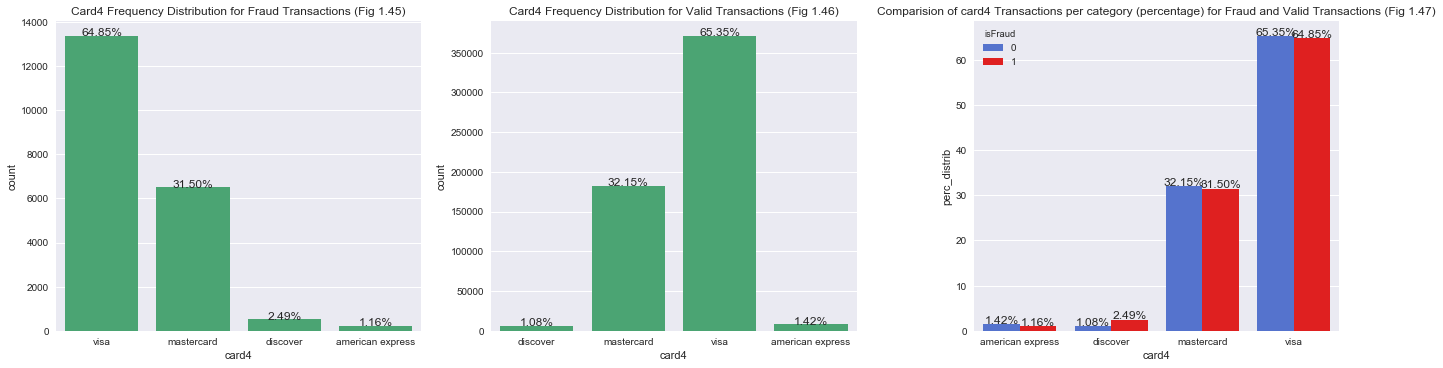

In [767]:
_, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 5), constrained_layout=True)
vis_gen('card4', ["Card4 Frequency Distribution for Fraud Transactions (Fig 1.45)", "Card4 Frequency Distribution for Valid Transactions (Fig 1.46)"],[ax1, ax2, ax3], ['mediumseagreen'], ["royalblue", 'r'])
set_vis_metadata([ax3], ["Comparision of card4 Transactions per category (percentage) for Fraud and Valid Transactions (Fig 1.47)"])


- In Fig 1.45 and Fig 1.46 we can see the card4 (Card company) frequency distribution used for Fraud and Valid Transactions.
- In both the cases the Visa has recorded highest number of transactions.
- In Fig 1.47 it is evident that the distribution is almost similar in case of Frad and Valid Transactions for all the card companies.

In [768]:
display(EDA.category_distrib(train_df, 'card6'))

,isFraud,card6,value_count,perc_distrib
0,0,charge card,15,0.002639
1,0,credit,139036,24.463310
2,0,debit,429264,75.528772
3,0,debit or credit,30,0.005278
4,1,credit,9950,48.244763
5,1,debit,10674,51.755237


- Distribution for card6

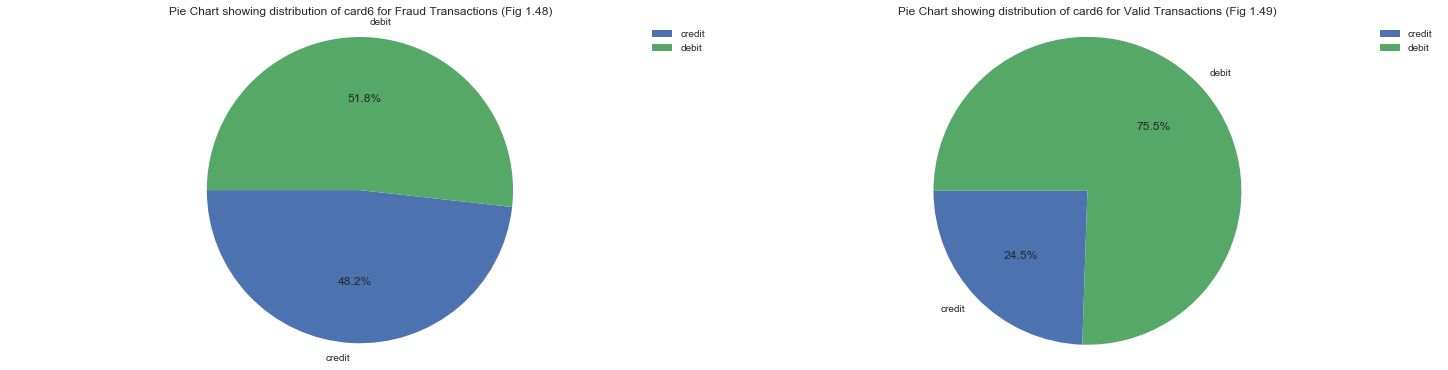

In [769]:

cat_dev = EDA.category_distrib(train_df, "card6")
f_cat_dev,v_cat_dev = EDA.splitter(cat_dev, "isFraud", 1, 0)
_, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5), constrained_layout=True)
plot_pie(f_cat_dev['card6'].tolist(), f_cat_dev['perc_distrib'].tolist(),ax1)
plot_pie(["credit", "debit"], ["24.46","75.53"],ax2)

set_vis_metadata([ax1,ax2], ["Pie Chart showing distribution of card6 for Fraud Transactions (Fig 1.48)", "Pie Chart showing distribution of card6 for Valid Transactions (Fig 1.49)"])
ax1.legend()
ax2.legend()

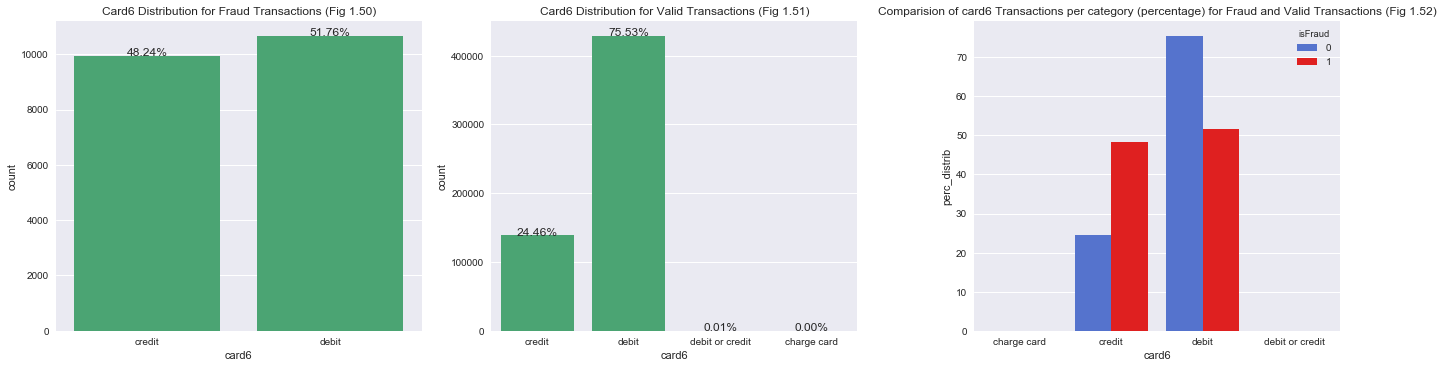

In [770]:
_, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 5), constrained_layout=True)
vis_gen('card6', ["Card6 Distribution for Fraud Transactions (Fig 1.50)", "Card6 Distribution for Valid Transactions (Fig 1.51)"],[ax1, ax2, ax3], ['mediumseagreen'],["royalblue", 'r'],False)
set_vis_metadata([ax3], ["Comparision of card6 Transactions per category (percentage) for Fraud and Valid Transactions (Fig 1.52)"])


- In Fig 1.50 and Fig 1.51 we can see the card6 (Card Type) frequency distribution used for Fraud and Valid Transactions.
- It is evident that as compared to Valid transactions the Fraud transactions have higer Credit Card usage.

### Part 1 Important Findings:

- The distribution and plot for TransactionAmt is almost similar for Valid and Fraud Transactions with mean on higer side for Fradulent transactions.
- Mobile devices are used more in case of Fradulent transactions as compared to Valid transactions.
- Windows, IOS and MAC OS are the top 3 device info categories in Fraud and Valid transactions.
- Gmail is most frequently used domain for both Fraud and Valid Transactions.
- Visa card is the most frequently used card type for both Fraud and Valid Transactions.
- In case of Fradulent transactions the credit card is more preferred as compared to the case of Valid Transactions.
- The most frequent billing country is addr2 = 87

## Part 2 - Transaction Frequency

In [771]:
display(train_df['addr2'].mode())

0    87.0
dtype: float64

In [772]:
freq_df = train_df.loc[train_df['addr2'] == 87.0]
freq_df = freq_df[["TransactionID","isFraud","TransactionDT","addr2"]]

- The most frequent field in addr2 is 87 so filtering the dataset using this informaion and required fields only.

In [773]:
EDA.display_df_meta(freq_df, 'TransactionDT and ADDR2', 5)

TransactionDT and ADDR2 Dataframe Shape:(520481, 4)


,TransactionID,isFraud,TransactionDT,addr2
0,2987000,0,86400,87.0
1,2987001,0,86401,87.0
2,2987002,0,86469,87.0
3,2987003,0,86499,87.0
4,2987004,0,86506,87.0


In [774]:
#Checking if the TransactionDT field is monotonously increasing for the whole dataset
print(pd.Index(freq_df['TransactionDT']).is_monotonic_increasing)

True


In [775]:
seconds_in_min = 60
min_in_hr = 60
hrs_in_day = 24

seconds_in_day = seconds_in_min * min_in_hr * hrs_in_day
print("No of seconds in a day: "+str(seconds_in_day))

No of seconds in a day: 86400


### Analysis of TransactionDT
- The first value of TransactionDT field is 86400, this seems to be the total count of number of seconds in a day. (60 (sec) X 60 (min) X 24 (hour)) = 86400
- Furhtermore it can be seen that this value is monotonously increasing, so it means all the entries are noted starting from a particular time of the day for a given period in increasing time-series manner.
- So in the following calculations I have "binned" every value of the TransactionDT into an hour slot ranging from 0-23 for each day.

In [776]:
# Function to Bin TransactionDT to hour or minutes as per the requirement.
def time_slot_bin(df, case):
    if case == 1:
        return df['TransactionDT'].transform(lambda x: int((x - seconds_in_day) / (min_in_hr*seconds_in_min)) % hrs_in_day)
    else:
        return df['TransactionDT'].transform(lambda x: int((x - seconds_in_day) / seconds_in_min) % (hrs_in_day*min_in_hr))
    

In [777]:
freq_df['hour_slot'] = time_slot_bin(freq_df, 1)

In [778]:
freq_df.groupby('hour_slot').size()

hour_slot
0     33203
1     28419
2     22331
3     16530
4     10960
5      7015
6      4624
7      2923
8      2161
9      2244
10     3379
11     6466
12    11861
13    19153
14    26262
15    30800
16    34714
17    36390
18    37167
19    37577
20    37267
21    37200
22    36591
23    35244
dtype: int64

In [779]:
#Split the data according to isFraud
frq_fraud_df, frq_valid_df = EDA.splitter(freq_df, "isFraud", 1, 0)

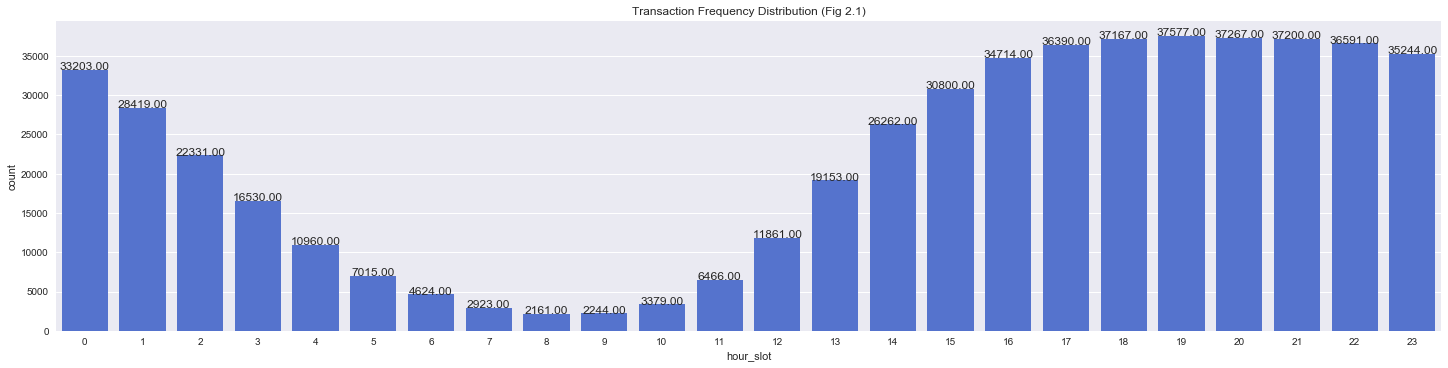

In [780]:
_, (ax1) = plt.subplots(1,1, figsize=(20, 5), constrained_layout=True)
#Ref for countplot: https://seaborn.pydata.org/generated/seaborn.countplot.html#seaborn.countplot
sb.countplot(x='hour_slot',data=freq_df, ax=ax1, palette=['royalblue']).set_title("Transaction Frequency Distribution (Fig 2.1)")
EDA.pheight_set(ax1, adj_x = 0, perc=False)

- From Fig 2.1 it is evident that transaction frequency starts increasing around 10th hour and is at it's peak at around 19th hour and starts deacreasing after it to minimum at 8th hour.
- From this it can be inferred that for country with addr2=87 the waking hours are approximately from 9th hour to 23rd hour as the transaction frequency is monotonically increasing for most of this period and decreases sharply after that.

Text(0.5,1,'Transaction Frequency Distribution for Valid Transactions (Fig 2.3)')

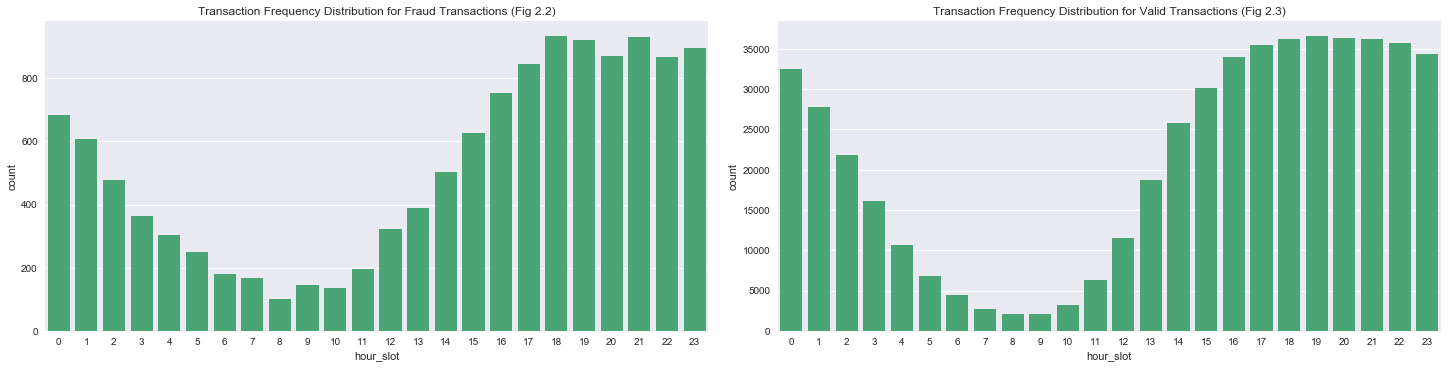

In [781]:
_, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5), constrained_layout=True)

#Ref for countplot: https://seaborn.pydata.org/generated/seaborn.countplot.html#seaborn.countplot
sb.countplot(x='hour_slot',data=frq_fraud_df, ax=ax1, palette=['mediumseagreen']).set_title("Transaction Frequency Distribution for Fraud Transactions (Fig 2.2)")
sb.countplot(x='hour_slot',data=frq_valid_df, ax=ax2, palette=['mediumseagreen']).set_title("Transaction Frequency Distribution for Valid Transactions (Fig 2.3)")


- Fig 2.2 and Fig 2.3 depict the transaction frequency distribution for Fraud and Valid Transactions respectively.

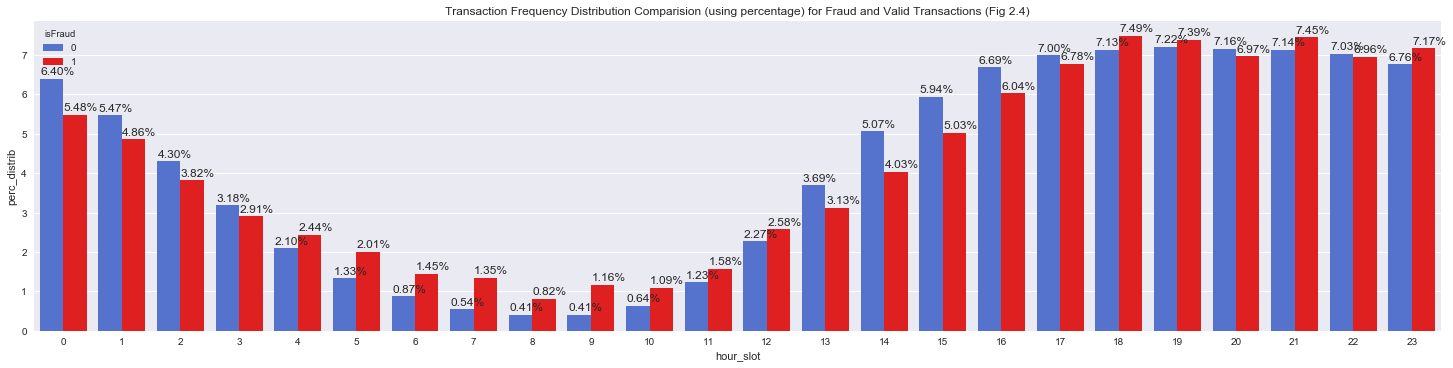

In [782]:
_,ax1 = plt.subplots(1,1, figsize=(20, 5), constrained_layout=True)

prod_distrib = EDA.category_distrib(freq_df, 'hour_slot')
#ref for barplot: https://seaborn.pydata.org/generated/seaborn.barplot.html
sb.barplot(x='hour_slot',y='perc_distrib', hue='isFraud', data=prod_distrib, ax=ax1, palette=fraud_plt_dict).set_title("Transaction Frequency Distribution Comparision (using percentage) for Fraud and Valid Transactions (Fig 2.4)")
EDA.pheight_set(ax1)

- Fig 2.4 shows the distribution comparision of valid and fraud transaction frequency for each hour of day. The distribution is almost similar and cyclic, however one interesting thing to note is that during the sleeping hours the Fradulent transactions are more frequent as compared to the waking hours.

### Part 2 Result

- From this section and all the plots it can be inferred that for country with addr2=87 the waking hours are approximately from 9th hour to 23rd hour as the transaction frequency is monotonically increasing for most of this period and decreases sharply after that.

## Part 3 - Product Code

In [783]:
# reference (groupby and mean): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.mean.html

def calc_avg_by_cat(calc_df, cat1, cat2, name):
    calc_mean_df = calc_df.groupby(cat1)[cat2].mean().reset_index(name=name)
    display(calc_mean_df)
    return calc_mean_df

EDA.cal_mean_by_category  = calc_avg_by_cat

In [784]:
prod_df = train_df[["TransactionID","isFraud","TransactionAmt","ProductCD", "card6"]]

In [785]:
EDA.display_df_meta(prod_df, "ProductCD Dataframe", 10)

ProductCD Dataframe Dataframe Shape:(590540, 5)


,TransactionID,isFraud,TransactionAmt,ProductCD,card6
0,2987000,0,68.5,W,credit
1,2987001,0,29.0,W,credit
2,2987002,0,59.0,W,debit
3,2987003,0,50.0,W,debit
4,2987004,0,50.0,H,credit
5,2987005,0,49.0,W,debit
6,2987006,0,159.0,W,debit
7,2987007,0,422.5,W,debit
8,2987008,0,15.0,H,debit
9,2987009,0,117.0,W,debit


In [786]:
prod_df.groupby('ProductCD').size()

ProductCD
C     68519
H     33024
R     37699
S     11628
W    439670
dtype: int64

In [787]:
cost_df = EDA.cal_mean_by_category(prod_df, 'ProductCD', 'TransactionAmt', "TransactionAmt Mean")

,ProductCD,TransactionAmt Mean
0,C,42.872353
1,H,73.170058
2,R,168.306188
3,S,60.269487
4,W,153.158554


In [788]:
cmp_df = pd.concat([pd.DataFrame(cost_df.nlargest(1, 'TransactionAmt Mean')), pd.DataFrame(cost_df.nsmallest(1, 'TransactionAmt Mean'))]).reset_index(drop=True)
cmp_df["Answer"] = ["Most Expensive Product", "Least Expensive Product"]
display(cmp_df)

,ProductCD,TransactionAmt Mean,Answer
0,R,168.306188,Most Expensive Product
1,C,42.872353,Least Expensive Product


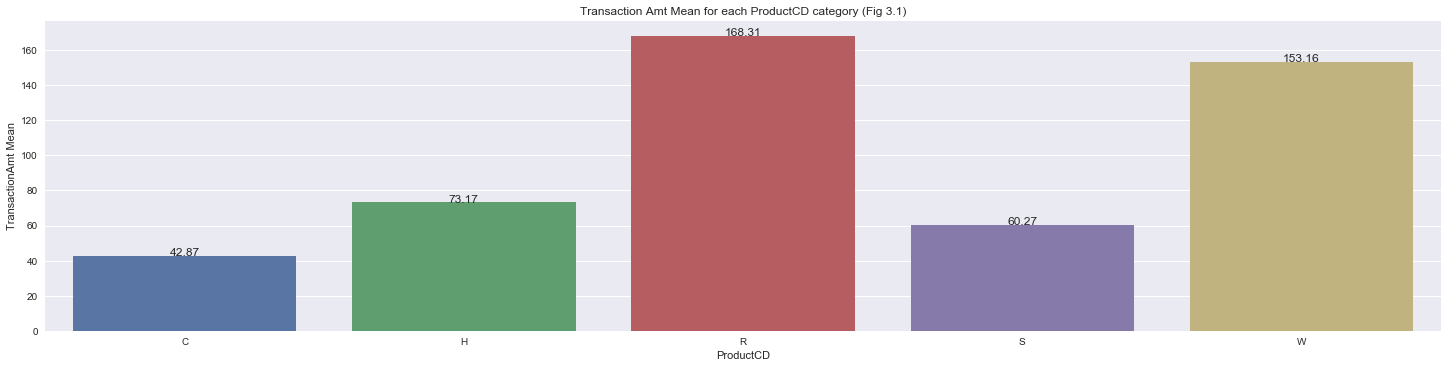

In [789]:
_,ax1 = plt.subplots(1,1, figsize=(20, 5), constrained_layout=True)
#Ref for barplot: https://seaborn.pydata.org/generated/seaborn.barplot.html
sb.barplot(x='ProductCD',y='TransactionAmt Mean', data=cost_df, ax=ax1).set_title("Transaction Amt Mean for each ProductCD category (Fig 3.1)")
EDA.pheight_set(ax1,adj_x=0, perc=False)

In [790]:
fraud_prod_df, valid_prod_df = EDA.splitter(prod_df, "isFraud", 1, 0)

In [791]:
fraud_cost_df = EDA.cal_mean_by_category(fraud_prod_df, 'ProductCD', 'TransactionAmt', "TransactionAmt Mean")

,ProductCD,TransactionAmt Mean
0,C,48.878796
1,H,156.691233
2,R,244.074334
3,S,63.288630
4,W,229.047325


In [792]:
cmp_df = pd.concat([pd.DataFrame(fraud_cost_df.nlargest(1, 'TransactionAmt Mean')), pd.DataFrame(fraud_cost_df.nsmallest(1, 'TransactionAmt Mean'))]).reset_index(drop=True)
cmp_df["Answer"] = ["Most Expensive Product", "Least Expensive Product"]
display(cmp_df)

,ProductCD,TransactionAmt Mean,Answer
0,R,244.074334,Most Expensive Product
1,C,48.878796,Least Expensive Product


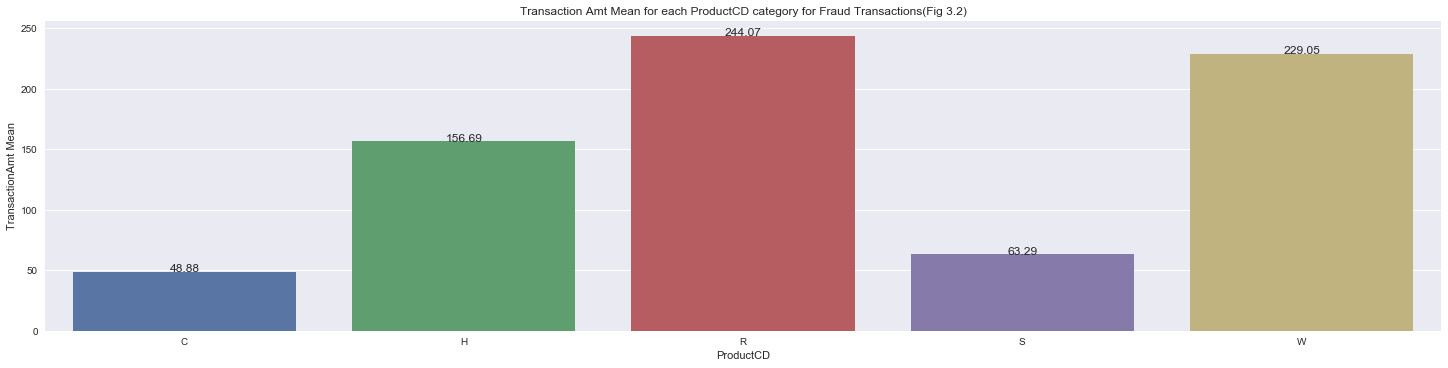

In [793]:
#Plotting the ProductCD vs TransactionAmt Mean 
_,ax1 = plt.subplots(1,1, figsize=(20, 5), constrained_layout=True)
#Ref for barplot: https://seaborn.pydata.org/generated/seaborn.barplot.html
sb.barplot(x='ProductCD',y='TransactionAmt Mean', data=fraud_cost_df, ax=ax1).set_title("Transaction Amt Mean for each ProductCD category for Fraud Transactions(Fig 3.2)")
EDA.pheight_set(ax1,adj_x=0, perc=False)

- Plot of ProductCD vs TransactionAmt Mean 

In [794]:
valid_cost_df = EDA.cal_mean_by_category(valid_prod_df, 'ProductCD', 'TransactionAmt', "TransactionAmt Mean")

,ProductCD,TransactionAmt Mean
0,C,42.077463
1,H,68.990016
2,R,165.327516
3,S,60.080205
4,W,151.578232


In [795]:
cmp_df = pd.concat([pd.DataFrame(valid_cost_df.nlargest(1, 'TransactionAmt Mean')), pd.DataFrame(valid_cost_df.nsmallest(1, 'TransactionAmt Mean'))]).reset_index(drop=True)
cmp_df["Answer"] = ["Most Expensive Product", "Least Expensive Product"]
display(cmp_df)

,ProductCD,TransactionAmt Mean,Answer
0,R,165.327516,Most Expensive Product
1,C,42.077463,Least Expensive Product


- From the analysis presented it can be noted that the mean TransactionAmt for Product code R is maximum in cases of both Valid and Fraud transaction and the mean TransactionAmt is minimum for Product code C in both the cases.
- So most expensive product: Product R
- cheapest product: C

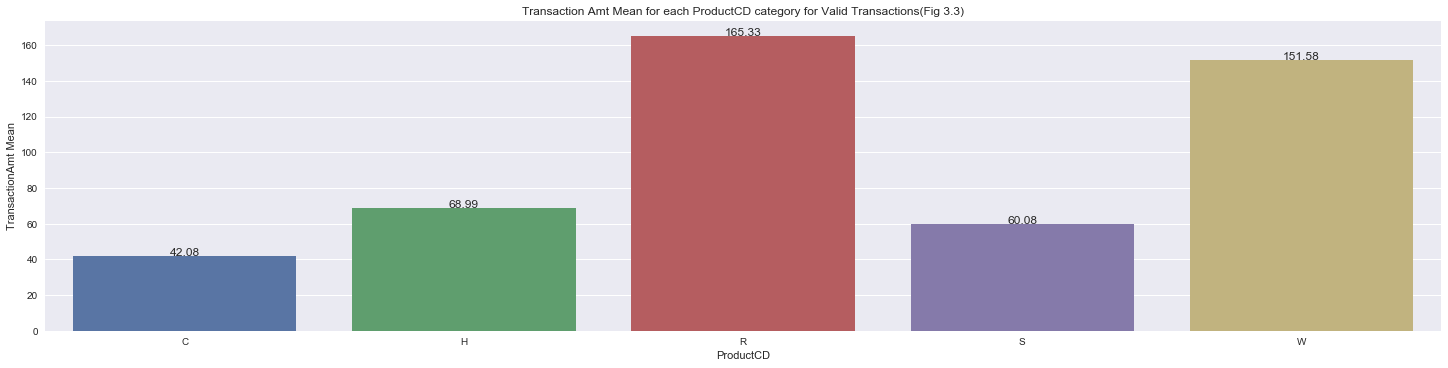

In [796]:
_,ax1 = plt.subplots(1,1, figsize=(20, 5), constrained_layout=True)
#Ref for barplot: https://seaborn.pydata.org/generated/seaborn.barplot.html
sb.barplot(x='ProductCD',y='TransactionAmt Mean', data=valid_cost_df, ax=ax1).set_title("Transaction Amt Mean for each ProductCD category for Valid Transactions(Fig 3.3)")
EDA.pheight_set(ax1,adj_x=0, perc=False)

Figures 3.1, 3.2, 3.3 show that the Mean TransactionAmt for each Product Code, it is highest for code R and minimum for code C

In [797]:
valid_cost_df['isFraud'] = 0
fraud_cost_df['isFraud'] = 1

total_cost_df = pd.concat([valid_cost_df, fraud_cost_df])
display(total_cost_df)

,ProductCD,TransactionAmt Mean,isFraud
0,C,42.077463,0
1,H,68.990016,0
2,R,165.327516,0
3,S,60.080205,0
4,W,151.578232,0
0,C,48.878796,1
1,H,156.691233,1
2,R,244.074334,1
3,S,63.288630,1
4,W,229.047325,1


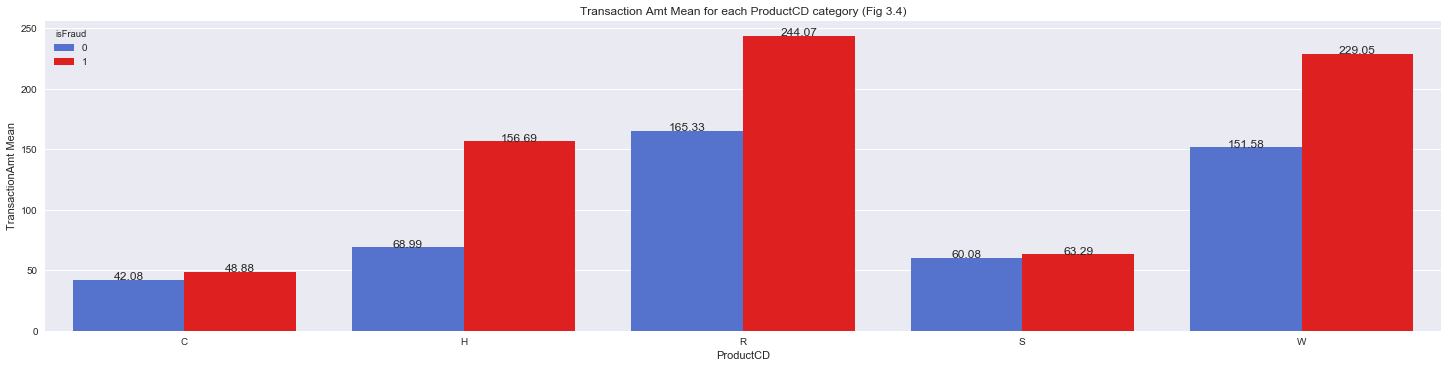

In [798]:
_,ax1 = plt.subplots(1,1, figsize=(20, 5), constrained_layout=True)

sb.barplot(x='ProductCD',y='TransactionAmt Mean', hue="isFraud", data=total_cost_df, ax=ax1, palette=fraud_plt_dict).set_title("Transaction Amt Mean for each ProductCD category (Fig 3.4)")
EDA.pheight_set(ax1,adj_x=0, perc=False)

### Part 3 Result

- Costliest Product is R
- Cheapest Product is C

## Part 4 - Correlation Coefficient

In [799]:
transac_time_df = train_df[["TransactionID","isFraud","TransactionDT","TransactionAmt"]]
transac_time_df = transac_time_df.dropna()
EDA.display_df_meta(transac_time_df, "Transaction Amt", 5)

Transaction Amt Dataframe Shape:(590540, 4)


,TransactionID,isFraud,TransactionDT,TransactionAmt
0,2987000,0,86400,68.5
1,2987001,0,86401,29.0
2,2987002,0,86469,59.0
3,2987003,0,86499,50.0
4,2987004,0,86506,50.0


In [800]:
transac_time_df = transac_time_df.loc[transac_time_df['TransactionAmt'] < 30000]

In [801]:
#Binning the transactionDT to min and hours of the day
transac_time_df['hour_slot'] = time_slot_bin(transac_time_df, 1)
transac_time_df['min_slot'] = time_slot_bin(transac_time_df, 2)

In [802]:
transac_time_df.groupby('min_slot').size().reset_index(name='count')

,min_slot,count
0,0,674
1,1,670
2,2,610
3,3,647
4,4,613
5,5,692
6,6,625
7,7,673
8,8,654
9,9,685


In [803]:
EDA.display_df_meta(transac_time_df, "Transaction Amt", 5)

Transaction Amt Dataframe Shape:(590538, 6)


,TransactionID,isFraud,TransactionDT,TransactionAmt,hour_slot,min_slot
0,2987000,0,86400,68.5,0,0
1,2987001,0,86401,29.0,0,0
2,2987002,0,86469,59.0,0,1
3,2987003,0,86499,50.0,0,1
4,2987004,0,86506,50.0,0,1


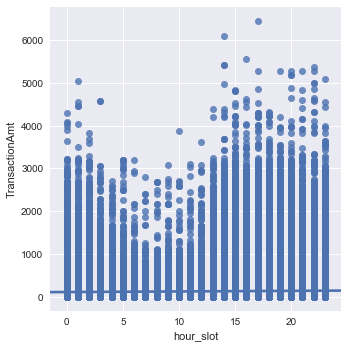

In [804]:
#Reference: https://seaborn.pydata.org/generated/seaborn.lmplot.html
sb.lmplot(x="hour_slot", y="TransactionAmt", data=transac_time_df)

- Plot of hour of the day vs TransactionAmt

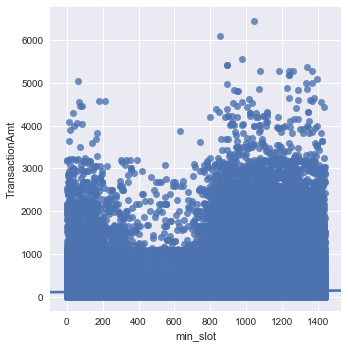

In [805]:
sb.lmplot(x="min_slot", y="TransactionAmt", data=transac_time_df)

- Plot of minute of the day vs TransactionAmt

- As it can be observed from the 2 scatter plots above the Correlation bewteen the single transaction amount and time of the day (be it in minutes or hours) is not high. According to the calculation presented in the 2 cells below it's just 0.04

In [806]:
transac_time_df['hour_slot'].corr(transac_time_df['TransactionAmt'])

0.045370965898569995

In [807]:
transac_time_df['min_slot'].corr(transac_time_df['TransactionAmt'])

0.04538832541252531

### In the following section we will sum together the Transaction Amount of transactions occuring in a single minute and then check the correlation between this sum and minute of the day and we will do this for hour of the day too.

In [808]:
#reference (groupby and sum): https://stackoverflow.com/questions/39922986/pandas-group-by-and-sum/39923815
trns_sum_df = transac_time_df.groupby('min_slot')['TransactionAmt'].sum().reset_index(name="TransactionAmt Sum")

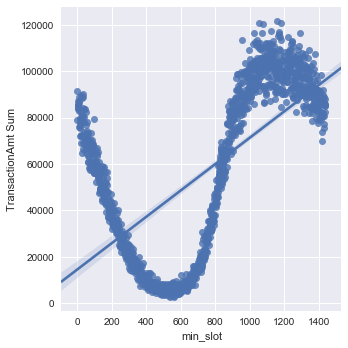

In [809]:
sb.lmplot(x="min_slot", y="TransactionAmt Sum", data=trns_sum_df)

- Plot of minute of the day and TransactionAmt Sum for that minute

In [810]:
trns_sum_df['min_slot'].corr(trns_sum_df['TransactionAmt Sum'])

0.6325146915523747

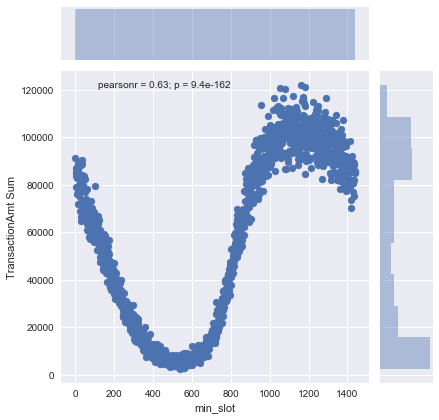

In [811]:
#Reference: https://seaborn.pydata.org/generated/seaborn.jointplot.html
sb.jointplot(x="min_slot", y="TransactionAmt Sum", data=trns_sum_df)

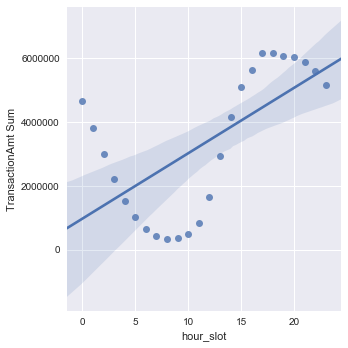

In [812]:
#reference (groupby and sum): https://stackoverflow.com/questions/39922986/pandas-group-by-and-sum/39923815
trns_sum_df = transac_time_df.groupby('hour_slot')['TransactionAmt'].sum().reset_index(name="TransactionAmt Sum")
sb.lmplot(x="hour_slot", y="TransactionAmt Sum", data=trns_sum_df)

- Plot of hour of the day and TransactionAmt Sum for that hour

In [813]:
trns_sum_df['hour_slot'].corr(trns_sum_df['TransactionAmt Sum'])

0.6407632134689994

- The 3 plots above depict that the correlation of Purchase amount (Sum of transactions each hour or minute) and time of the day (hour or minute) is high, its around 0.64.

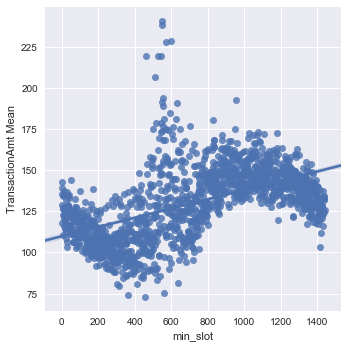

In [814]:
# reference (groupby and mean): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.mean.html
trns_mean_df = transac_time_df.groupby('min_slot')['TransactionAmt'].mean().reset_index(name="TransactionAmt Mean")
sb.lmplot(x="min_slot", y="TransactionAmt Mean", data=trns_mean_df)

- Plot of minute of the day and TransactionAmt Mean for that minute

In [815]:
trns_mean_df['min_slot'].corr(trns_mean_df['TransactionAmt Mean'])

0.5296747027502624

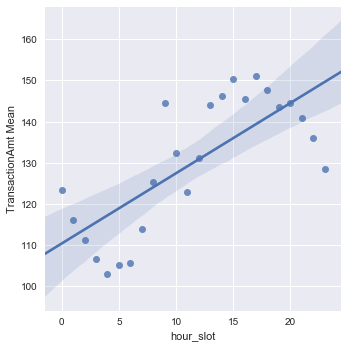

In [816]:
# reference (groupby and mean): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.mean.html
trns_mean_df = transac_time_df.groupby('hour_slot')['TransactionAmt'].mean().reset_index(name="TransactionAmt Mean")
sb.lmplot(x="hour_slot", y="TransactionAmt Mean", data=trns_mean_df)

- Plot of hour of the day and TransactionAmt Mean for that hour

In [817]:
trns_mean_df['hour_slot'].corr(trns_mean_df['TransactionAmt Mean'])

0.7435967343532418

- The 2 plots above depict that the correlation of Purchase amount mean (Mean of transactions each hour or minute) and time of the day (hour or minute) is high, its around 0.53 if compare it for each minute and 0.74 for each hour.

In [818]:
f_transac_time_df = transac_time_df.loc[transac_time_df['isFraud'] == 1]
v_transac_time_df = transac_time_df.loc[transac_time_df['isFraud'] == 0]

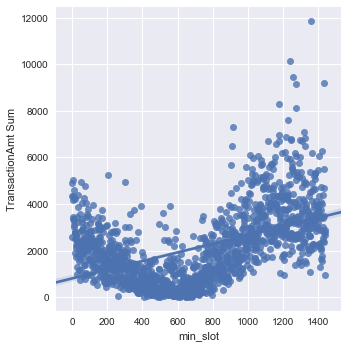

In [819]:
f_trns_sum_df = f_transac_time_df.groupby('min_slot')['TransactionAmt'].sum().reset_index(name="TransactionAmt Sum")
sb.lmplot(x="min_slot", y="TransactionAmt Sum", data=f_trns_sum_df)

The plot above shows correlation between Purchase amount(mean) and minute of the day for Fraud Transactions and it's around 0.48

In [820]:
f_trns_sum_df['min_slot'].corr(f_trns_sum_df['TransactionAmt Sum'])

0.4849780084323182

In [821]:
# reference (groupby and mean): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.mean.html
f_trns_mean_df = f_transac_time_df.groupby('min_slot')['TransactionAmt'].mean().reset_index(name="TransactionAmt Mean")

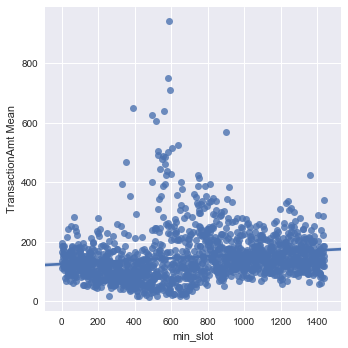

In [822]:
sb.lmplot(x="min_slot", y="TransactionAmt Mean", data=f_trns_mean_df)

In [823]:
f_trns_mean_df['min_slot'].corr(f_trns_mean_df['TransactionAmt Mean'])

0.15931268503752252

In [824]:
# reference (groupby and mean): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.mean.html
f_trns_mean_df = f_transac_time_df.groupby('hour_slot')['TransactionAmt'].mean().reset_index(name="TransactionAmt Mean")

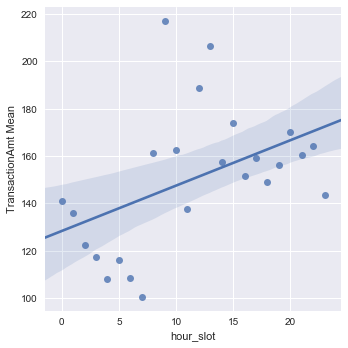

In [825]:
sb.lmplot(x="hour_slot", y="TransactionAmt Mean", data=f_trns_mean_df)

In [826]:
f_trns_mean_df['hour_slot'].corr(f_trns_mean_df['TransactionAmt Mean'])

0.4557227458652254

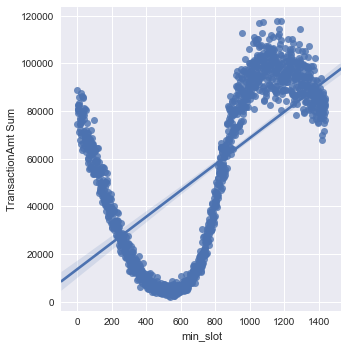

In [827]:
#reference (groupby and sum): https://stackoverflow.com/questions/39922986/pandas-group-by-and-sum/39923815

v_trns_sum_df = v_transac_time_df.groupby('min_slot')['TransactionAmt'].sum().reset_index(name="TransactionAmt Sum")
sb.lmplot(x="min_slot", y="TransactionAmt Sum", data=v_trns_sum_df)

The plot above shows correlation between Purchase amount and minute of the day for Valid Transaction and it's around 0.63, this similar to the one observed in the full training set without filetering out Fraud transactions.

In [828]:
v_trns_sum_df['min_slot'].corr(v_trns_sum_df['TransactionAmt Sum'])

0.6312522948884706

In [829]:
# reference (groupby and mean): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.mean.html
v_trns_mean_df = v_transac_time_df.groupby('min_slot')['TransactionAmt'].mean().reset_index(name="TransactionAmt Mean")

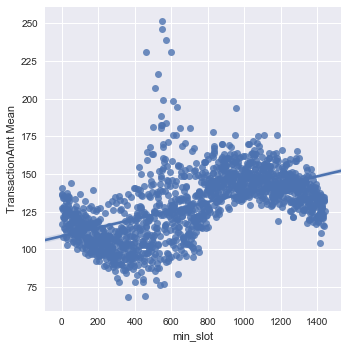

In [830]:
sb.lmplot(x="min_slot", y="TransactionAmt Mean", data=v_trns_mean_df)

In [831]:
v_trns_mean_df['min_slot'].corr(v_trns_mean_df['TransactionAmt Mean'])

0.5296888026027217

In [832]:
# reference (groupby and mean): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.mean.html
v_trns_mean_df = v_transac_time_df.groupby('hour_slot')['TransactionAmt'].mean().reset_index(name="TransactionAmt Mean")

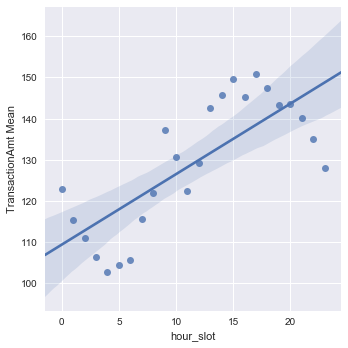

In [833]:
sb.lmplot(x="hour_slot", y="TransactionAmt Mean", data=v_trns_mean_df)

The plot above shows correlation between Transaction Amt Mean and hour of the day for Valid Transaction and it's around 0.76

In [834]:
v_trns_mean_df['hour_slot'].corr(v_trns_mean_df['TransactionAmt Mean'])

0.7614442725815294

###  Part 4 Findings

- Correlation between hour of the day and Purchase Amount sum is 0.64
- Correlation between hour of the day and Purchase Amount mean is 0.74

## Part 5 - Interesting Plot

### Correlation Plot

In [835]:
corr_df = train_df[required_cols]
corr_df['isFraud'] = train_df['isFraud']

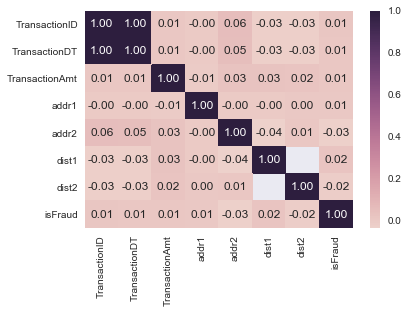

In [836]:
#Reference: https://seaborn.pydata.org/generated/seaborn.heatmap.html
sb.heatmap(corr_df.corr(), annot=True, fmt=".2f", cmap=sb.cubehelix_palette(300))

- This plot shows the correlation between several factors of the given dataset and can be used to examine their relationships

### Comparision of Card6 for Fraud and Valid Transactions

In [837]:
card_df = train_df[["isFraud", "TransactionAmt", "card6"]]
EDA.display_df_meta(card_df, "Transaction Amt and Card", 5)

Transaction Amt and Card Dataframe Shape:(590540, 3)


,isFraud,TransactionAmt,card6
0,0,68.5,credit
1,0,29.0,credit
2,0,59.0,debit
3,0,50.0,debit
4,0,50.0,credit


In [838]:
fraud_card_df, valid_card_df = EDA.splitter(card_df, "isFraud", 1, 0)

In [839]:
f_temp_df = fraud_card_df.groupby('card6')['TransactionAmt'].sum().reset_index(name="TransactionAmt Sum")
f_temp_df = f_temp_df.sort_values(by="TransactionAmt Sum", ascending=False)

f_temp_df['perc_distrib'] = f_temp_df['TransactionAmt Sum'].transform(lambda x: np.true_divide(x, x.sum())*100)

EDA.display_df_meta(f_temp_df, "Transaction Amt and Card", len(f_temp_df))

Transaction Amt and Card Dataframe Shape:(2, 3)


,card6,TransactionAmt Sum,perc_distrib
0,credit,1656751.371,53.811705
1,debit,1422042.280,46.188295


- The above table clearly shows that majority of fradulent transactions are done via Credit card

In [840]:
v_temp_df = valid_card_df.groupby('card6')['TransactionAmt'].sum().reset_index(name="TransactionAmt Sum")
v_temp_df = v_temp_df.sort_values(by="TransactionAmt Sum", ascending=False)

v_temp_df['perc_distrib'] = v_temp_df['TransactionAmt Sum'].transform(lambda x: np.true_divide(x,x.sum())*100)

EDA.display_df_meta(v_temp_df, "Transaction Amt and Card", len(v_temp_df))

Transaction Amt and Card Dataframe Shape:(4, 3)


,card6,TransactionAmt Sum,perc_distrib
2,debit,4.975716e+07,65.112784
1,credit,2.665571e+07,34.881962
3,debit or credit,3.121970e+03,0.004085
0,charge card,8.929220e+02,0.001168


- The above table clearly shows that majority of fradulent transactions are done via Dedit card

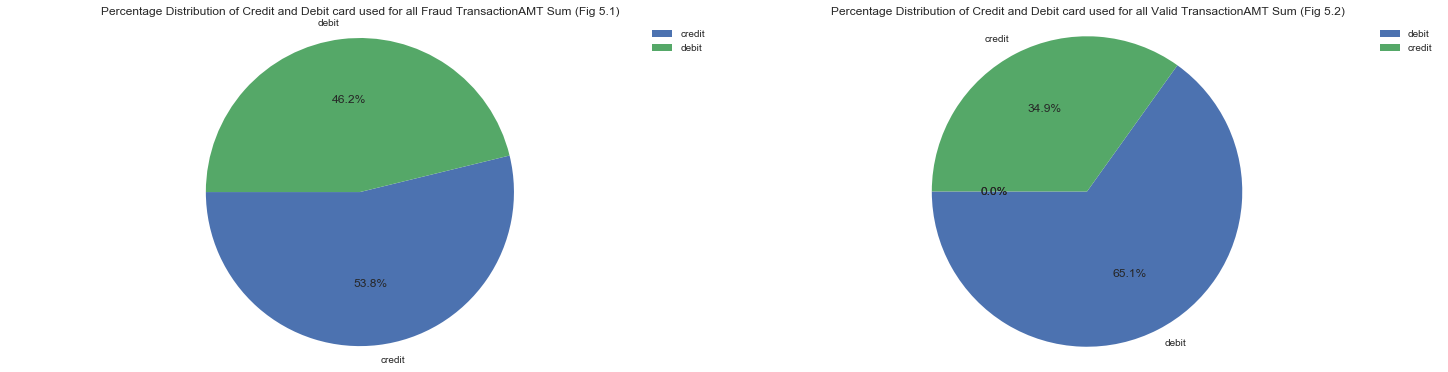

In [841]:
_, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5), constrained_layout=True)
plot_pie(["credit", "debit"], f_temp_df['perc_distrib'],ax1)
plot_pie(["debit", "credit","", ""], v_temp_df['perc_distrib'],ax2)
set_vis_metadata([ax1, ax2], ["Percentage Distribution of Credit and Debit card used for all Fraud TransactionAMT Sum (Fig 5.1)", "Percentage Distribution of Credit and Debit card used for all Valid TransactionAMT Sum (Fig 5.2)"])
ax1.legend()
ax2.legend()

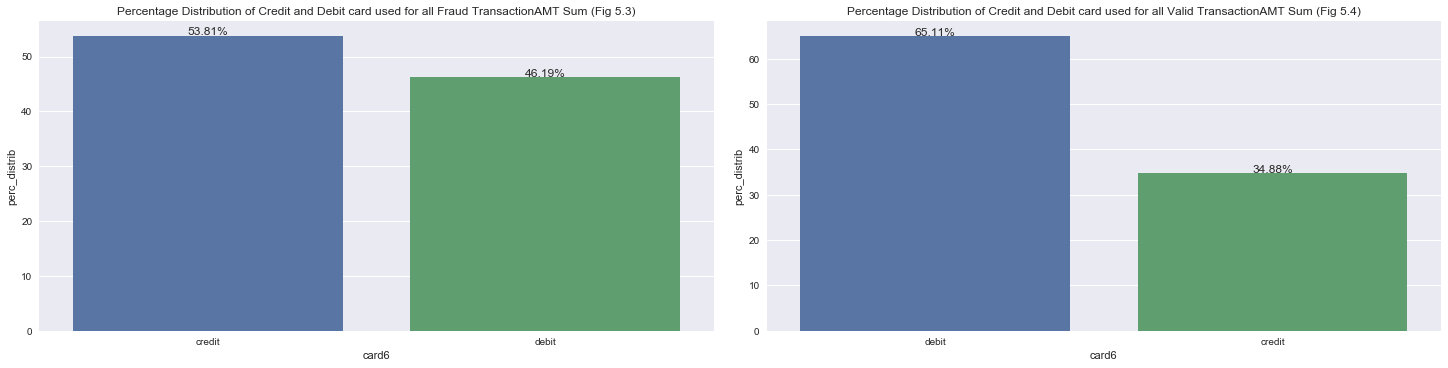

In [842]:
_, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5), constrained_layout=True)
sb.barplot(x='card6',y='perc_distrib', data=f_temp_df, ax=ax1)
sb.barplot(x='card6',y='perc_distrib', data=v_temp_df.nlargest(2, 'perc_distrib'), ax=ax2)
set_vis_metadata([ax1, ax2], ["Percentage Distribution of Credit and Debit card used for all Fraud TransactionAMT Sum (Fig 5.3)", "Percentage Distribution of Credit and Debit card used for all Valid TransactionAMT Sum (Fig 5.4)"])
EDA.pheight_set(ax1,adj_x=0)
EDA.pheight_set(ax2,adj_x=0)

- The credit card is used more for Fradulent transactions.
- For the valid transactions the Debit card is preffered.

In [843]:
dev_df = train_df[["isFraud", "TransactionAmt","DeviceInfo"]]
dev_df = dev_df.dropna()
EDA.display_df_meta(dev_df, "Transaction Amt and Device Info", 5)

Transaction Amt and Device Info Dataframe Shape:(118666, 3)


,isFraud,TransactionAmt,DeviceInfo
4,0,50.000,SAMSUNG SM-G892A Build/NRD90M
8,0,15.000,iOS Device
10,0,75.887,Windows
16,0,30.000,MacOS
17,0,100.000,Windows


In [844]:
fraud_dev_df, valid_dev_df = EDA.splitter(dev_df, "isFraud", 1, 0)

In [845]:
f_temp_df = fraud_dev_df.groupby('DeviceInfo')['TransactionAmt'].sum().reset_index(name="TransactionAmt Sum")
f_temp_df = f_temp_df.sort_values(by="TransactionAmt Sum", ascending=False)
f_temp_df['perc_distrib'] = f_temp_df['TransactionAmt Sum'].transform(lambda x: np.true_divide(x, x.sum())*100)
f_temp_df['isFraud'] = 1
EDA.display_df_meta(f_temp_df, "Transaction Amt and Card", 5)

Transaction Amt and Card Dataframe Shape:(420, 4)


,DeviceInfo,TransactionAmt Sum,perc_distrib,isFraud
398,iOS Device,269517.000,31.708945,1
360,Windows,261684.457,30.787439,1
148,MacOS,42741.000,5.028521,1
402,rv:11.0,19804.628,2.330034,1
93,KFFOWI Build/LVY48F,9365.000,1.101802,1


In [846]:
v_temp_df = valid_dev_df.groupby('DeviceInfo')['TransactionAmt'].sum().reset_index(name="TransactionAmt Sum")
v_temp_df = v_temp_df.sort_values(by="TransactionAmt Sum", ascending=False)
v_temp_df['perc_distrib'] = v_temp_df['TransactionAmt Sum'].transform(lambda x: np.true_divide(x,x.sum())*100)
v_temp_df['isFraud'] = 0
EDA.display_df_meta(v_temp_df, "Transaction Amt and Card", 5)

Transaction Amt and Card Dataframe Shape:(1740, 4)


,DeviceInfo,TransactionAmt Sum,perc_distrib,isFraud
1565,Windows,4129067.348,41.761195,0
1684,iOS Device,1910012.600,19.317779,0
712,MacOS,1370215.150,13.858292,0
1520,Trident/7.0,887631.132,8.977460,0
1699,rv:11.0,297988.510,3.013842,0


From the above two tables it is evident that Windows, IOS and MacOC are the most frequent DeviceInfo

In [847]:
device_i_df = f_temp_df.loc[f_temp_df["DeviceInfo"].isin(["Windows", "iOS Device", "MacOS"])]
device_i_df = pd.concat([device_i_df, v_temp_df.loc[v_temp_df["DeviceInfo"].isin(["Windows", "iOS Device", "MacOS"])]])
display(device_i_df)

,DeviceInfo,TransactionAmt Sum,perc_distrib,isFraud
398,iOS Device,269517.000,31.708945,1
360,Windows,261684.457,30.787439,1
148,MacOS,42741.000,5.028521,1
1565,Windows,4129067.348,41.761195,0
1684,iOS Device,1910012.600,19.317779,0
712,MacOS,1370215.150,13.858292,0


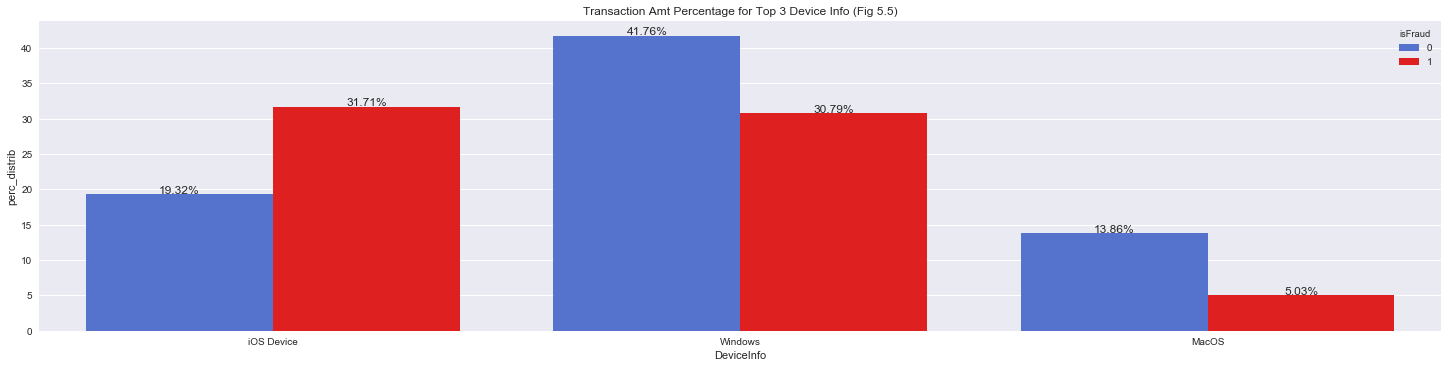

In [848]:
_, (ax1) = plt.subplots(1,1, figsize=(20, 5), constrained_layout=True)
sb.barplot(x='DeviceInfo',y='perc_distrib', data=device_i_df, ax=ax1, hue="isFraud", palette=fraud_plt_dict).set_title("Transaction Amt Percentage for Top 3 Device Info (Fig 5.5)")
EDA.pheight_set(ax1, adj_x=0)

- As it can be observed from the plot above the IOS device is used more for Fradulent transactions, one of the reasons for this can be attributed to Apple Pay, which eliminates the need of physical card.
- Valid Transactions are mainly done via Windows devices.

In [849]:
dev_df = train_df[["isFraud", "TransactionAmt","DeviceType"]]
dev_df = dev_df.dropna()
EDA.display_df_meta(dev_df, "Transaction Amt and Device Info", 5)

Transaction Amt and Device Info Dataframe Shape:(140810, 3)


,isFraud,TransactionAmt,DeviceType
4,0,50.000,mobile
8,0,15.000,mobile
10,0,75.887,desktop
11,0,16.495,desktop
16,0,30.000,desktop


In [850]:
fraud_dev_df, valid_dev_df = EDA.splitter(dev_df, "isFraud", 1, 0)

In [851]:
f_temp_df = fraud_dev_df.groupby('DeviceType')['TransactionAmt'].sum().reset_index(name="TransactionAmt Sum")
f_temp_df = f_temp_df.sort_values(by="TransactionAmt Sum", ascending=False)
f_temp_df['perc_distrib'] = f_temp_df['TransactionAmt Sum'].transform(lambda x: np.true_divide(x, x.sum())*100)
f_temp_df['isFraud'] = 1
EDA.display_df_meta(f_temp_df, "Transaction Amt and Card", 5)

Transaction Amt and Card Dataframe Shape:(2, 4)


,DeviceType,TransactionAmt Sum,perc_distrib,isFraud
1,mobile,546427.465,54.845323,1
0,desktop,449878.937,45.154677,1


In [852]:
v_temp_df = valid_dev_df.groupby('DeviceType')['TransactionAmt'].sum().reset_index(name="TransactionAmt Sum")
v_temp_df = v_temp_df.sort_values(by="TransactionAmt Sum", ascending=False)
v_temp_df['perc_distrib'] = v_temp_df['TransactionAmt Sum'].transform(lambda x: np.true_divide(x, x.sum())*100)
v_temp_df['isFraud'] = 0
EDA.display_df_meta(v_temp_df, "Transaction Amt and Card", 5)

Transaction Amt and Card Dataframe Shape:(2, 4)


,DeviceType,TransactionAmt Sum,perc_distrib,isFraud
0,desktop,7436412.511,69.127255,0
1,mobile,3321157.063,30.872745,0


- The above two tables depict that in case of Fradulent transactions mobile device is highly preferred.

In [853]:
device_t_df = pd.concat([v_temp_df, f_temp_df])
display(device_t_df)

,DeviceType,TransactionAmt Sum,perc_distrib,isFraud
0,desktop,7436412.511,69.127255,0
1,mobile,3321157.063,30.872745,0
1,mobile,546427.465,54.845323,1
0,desktop,449878.937,45.154677,1


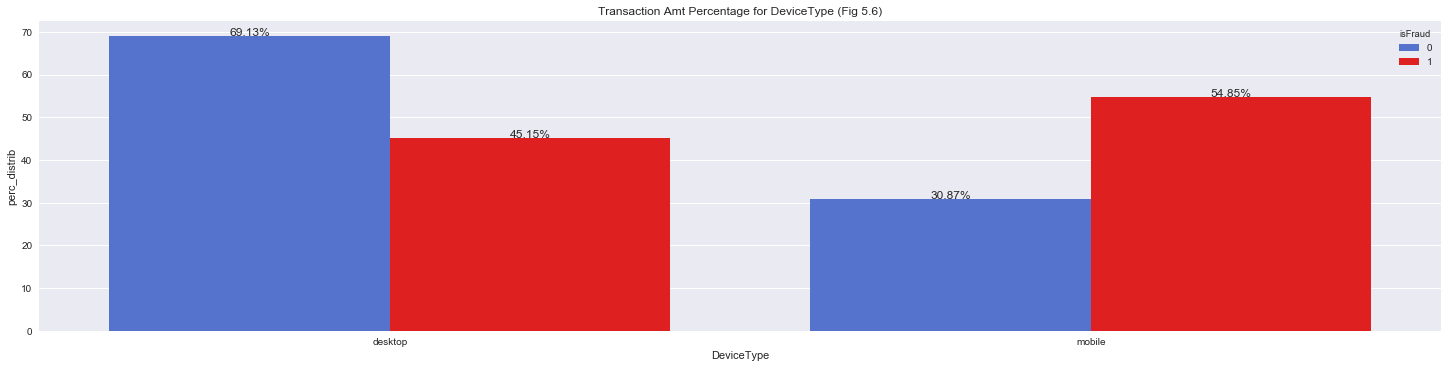

In [854]:
_, (ax1) = plt.subplots(1,1, figsize=(20, 5), constrained_layout=True)
sb.barplot(x='DeviceType',y='perc_distrib', data=device_t_df, ax=ax1, hue="isFraud", palette=fraud_plt_dict).set_title("Transaction Amt Percentage for DeviceType (Fig 5.6)")
EDA.pheight_set(ax1, adj_x=0)

- As you can observe from the plot in case of Fradulent transactions mobile device is highly preferred.

## Part 6 - Prediction Model

- Exploring Vista engineered features for Nan values

In [855]:
vest_list = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322', 'V323', 'V324']

for v_ftr in vest_list:
     print(v_ftr + ":" + str(train_df[v_ftr].isna().sum()/len(train_df) *100))

V1:47.29349409015477
V2:47.29349409015477
V3:47.29349409015477
V4:47.29349409015477
V5:47.29349409015477
V6:47.29349409015477
V7:47.29349409015477
V8:47.29349409015477
V9:47.29349409015477
V10:47.29349409015477
V11:47.29349409015477
V12:12.881938564703491
V13:12.881938564703491
V14:12.881938564703491
V15:12.881938564703491
V16:12.881938564703491
V17:12.881938564703491
V18:12.881938564703491
V19:12.881938564703491
V20:12.881938564703491
V21:12.881938564703491
V22:12.881938564703491
V23:12.881938564703491
V24:12.881938564703491
V25:12.881938564703491
V26:12.881938564703491
V27:12.881938564703491
V28:12.881938564703491
V29:12.881938564703491
V30:12.881938564703491
V31:12.881938564703491
V32:12.881938564703491
V33:12.881938564703491
V34:12.881938564703491
V35:28.612625732380533
V36:28.612625732380533
V37:28.612625732380533
V38:28.612625732380533
V39:28.612625732380533
V40:28.612625732380533
V41:28.612625732380533
V42:28.612625732380533
V43:28.612625732380533
V44:28.612625732380533
V45:28.6

- Exploring id features for Nan values

In [856]:
id_list = ['id_03', 'id_04', 'id_09', 'id_10', 'id_12', 'id_14', 'id_15', 'id_16','id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

for id_val in id_list:
    print(id_val + ":" + str(train_df[id_val].isna().sum()/len(train_df) *100))

id_03:88.76892335828225
id_04:88.76892335828225
id_09:87.31229044603245
id_10:87.31229044603245
id_12:75.5760829071697
id_14:86.4456260371863
id_15:76.12608798726589
id_16:78.098011989027
id_28:76.12727334304196
id_29:76.12727334304196
id_30:86.8654113184543
id_31:76.24513157449114
id_32:86.86185525112609
id_33:87.58949436109323
id_34:86.82477054898906
id_35:76.12608798726589
id_36:76.12608798726589
id_37:76.12608798726589
id_38:76.12608798726589


- Exploring M features for Nan Values

In [857]:
m_list = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
for id_val in m_list:
    print(id_val + ":" + str(train_df[id_val].isna().sum()/len(train_df) *100))

M1:45.90713584177194
M2:45.90713584177194
M3:45.90713584177194
M4:47.658753005723575
M5:59.34940901547736
M6:28.678836319300977
M7:58.63531682866528
M8:58.633115453652586
M9:58.633115453652586


In [858]:
#read the testing CSV (Transaction + ID)
trns_test_df = hdl.read_from_csv(TRANSACTION_TEST_CSV)
id_test_df = hdl.read_from_csv(ID_TEST_CSV)

Reading Data from: /Users/hardik/Desktop/CSE-519/HW2/ieee-fraud-detection/test_transaction.csv
Reading Data from: /Users/hardik/Desktop/CSE-519/HW2/ieee-fraud-detection/test_identity.csv


In [859]:
test_df = hdl.merge_dataframe(trns_test_df, id_test_df,'TransactionID','left')

Merging the Dataframes
Dataframes Merged


In [860]:
EDA.display_df_meta(test_df, 'Test', 5)

Test Dataframe Shape:(506691, 433)


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Modelling the data

In [861]:
class ML_Helper:
    
    @staticmethod
    def feature_selector(ftr_list, df):
        return (df[ftr_list], df['isFraud'])
    
    @staticmethod
    def error_measure(pred_result, true_pred):
        m_err = mean_squared_error(true_pred, pred_result)
        r_err = np.sqrt(m_err)
        
        print("Error Analysis-----------")
        print("Mean Squared Error for the result: "+str(m_err))
        print("Root Mean Squared Error for the result: "+str(r_err))
    
    @staticmethod
    def accuracy_measure(pred_result, true_pred):
        acc = accuracy_score(pred_result,true_pred)
        roc_acc = roc_auc_score(true_pred,pred_result)
        
        print("Accuracy Analysis-----------")
        print("Accuracy for the result: "+str(acc))
        print("ROC area under the curve for the result: "+str(roc_acc))
    
    @staticmethod
    def encode_df(df):
        pass

    @staticmethod
    def train_model(model, data, labels, test):
        mdl =  model.fit(data, labels)
        return mdl, mdl.predict(test)

    @staticmethod
    def generate_submission(test_df, pred_result, path, model_name):
        sub_df = pd.DataFrame(test_df['TransactionID'])
        sub_df['isFraud'] = pred_result
        EDA.display_df_meta(sub_df, "Submission for "+model_name, 10)
        sub_df.to_csv(path, index = False)
        hdl.write_to_csv(sub_df,path)


In [862]:
def encode_util(df):    
    os_dict = {"MacOS": 1, "iOS Device": 2, "Windows":3, "Trident/7.0":4, "rv:11.0": 5, "rv:57.0":6}
    p_dict = {"W":1, "C":2, "R":3, "H":4, "S":5}
    dev_dict = {"desktop": 1, "mobile": 2}
    card4_dict = {"visa": 1, "mastercard":2, "american express":3, "discover":4}
    card6_dict = {"debit":1, "credit":2}
    m_dict = {"T":1, "F":2}
    m4_dict = {"M1":1, "M2":2, "M0":3}
    p_email_dict = {"gmail.com":1, "yahoo.com":2, "hotmail.com":3, "anonymous.com": 4, "aol.com": 5, "comcast.net": 6, "icloud.com":7, "outlook.com":8, "msn.com":9}
    r_email_dict = {"gmail.com":1, "yahoo.com":2, "hotmail.com":3, "anonymous.com": 4, "aol.com": 5, "comcast.net": 6, "icloud.com":7, "outlook.com":8, "msn.com":9}

    df['DeviceInfo'] = df["DeviceInfo"].transform(lambda x: 0 if (x not in os_dict.keys()) else os_dict[x])

    df['DeviceType'] = df["DeviceType"].transform(lambda x: 0 if (x not in dev_dict.keys()) else dev_dict[x])
    df['ProductCD'] =  df["ProductCD"].transform(lambda x: 0 if (x not in p_dict.keys()) else p_dict[x])

    df['card4'] = df["card4"].transform(lambda x: 0 if (x not in card4_dict.keys()) else card4_dict[x])
    df['card6'] = df["card6"].transform(lambda x: 0 if (x not in card6_dict.keys()) else card6_dict[x])
    df['P_emaildomain'] = df["P_emaildomain"].transform(lambda x: 0 if (x not in p_email_dict.keys()) else p_email_dict[x])
    df['R_emaildomain'] = df["R_emaildomain"].transform(lambda x: 0 if (x not in r_email_dict.keys()) else r_email_dict[x])

    for m in ('M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9'):
        df[m] = df[m].transform(lambda x: 0 if (x not in m_dict.keys()) else m_dict[x])

    df['M4'] = df['M4'].transform(lambda x: 0 if (x not in m4_dict.keys()) else m4_dict[x])

In [863]:
ML_Helper.encode_df = encode_util

In [864]:
# Modelling the training dataset with selected features. 
# These features were selected after multiple experimentation and accuracy and ROC AUC testing 
# and generated best score for me on the Kaggle
modelling_cols = ["TransactionDT", "TransactionAmt", "ProductCD", "DeviceType", "DeviceInfo","addr1", "addr2",
                  "P_emaildomain", "R_emaildomain", "card1","card2","card3","card4", "card5","card6", 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'V1', 'V2', 'D1', 'D2', 'D3', 'D4', 'D10', 'D11', 'D15', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 
                  'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_13', 'id_17', 'id_19', 'id_20','M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9','id_03', 'id_04', 'id_09', 'id_10', 'id_14']

mdl_df, res = ML_Helper.feature_selector(modelling_cols, train_df)

for col in mdl_df.columns:
    if mdl_df[col].isna().sum() > 0:
        mdl_df[col].fillna(mdl_df[col].mode()[0], inplace=True)

EDA.display_df_meta(mdl_df, "Data Frame for Modelling the features", 5)


Data Frame for Modelling the features Dataframe Shape:(590540, 147)


,TransactionDT,TransactionAmt,ProductCD,DeviceType,DeviceInfo,addr1,addr2,P_emaildomain,R_emaildomain,card1,...,M5,M6,M7,M8,M9,id_03,id_04,id_09,id_10,id_14
0,86400,68.5,W,desktop,Windows,315.0,87.0,gmail.com,gmail.com,13926,...,F,T,F,F,T,0.0,0.0,0.0,0.0,-300.0
1,86401,29.0,W,desktop,Windows,325.0,87.0,gmail.com,gmail.com,2755,...,T,T,F,F,T,0.0,0.0,0.0,0.0,-300.0
2,86469,59.0,W,desktop,Windows,330.0,87.0,outlook.com,gmail.com,4663,...,F,F,F,F,F,0.0,0.0,0.0,0.0,-300.0
3,86499,50.0,W,desktop,Windows,476.0,87.0,yahoo.com,gmail.com,18132,...,T,F,F,F,T,0.0,0.0,0.0,0.0,-300.0
4,86506,50.0,H,mobile,SAMSUNG SM-G892A Build/NRD90M,420.0,87.0,gmail.com,gmail.com,4497,...,F,F,F,F,T,0.0,0.0,0.0,0.0,-480.0


In [865]:
display(res)

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
590510    0
590511    0
590512    0
590513    0
590514    0
590515    0
590516    0
590517    0
590518    0
590519    0
590520    0
590521    0
590522    0
590523    0
590524    0
590525    0
590526    1
590527    0
590528    0
590529    0
590530    0
590531    0
590532    0
590533    0
590534    0
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 590540, dtype: int64

In [866]:
# Encoding the training set
ML_Helper.encode_df(mdl_df)
display(mdl_df)

,TransactionDT,TransactionAmt,ProductCD,DeviceType,DeviceInfo,addr1,addr2,P_emaildomain,R_emaildomain,card1,...,M5,M6,M7,M8,M9,id_03,id_04,id_09,id_10,id_14
0,86400,68.500,1,1,3,315.0,87.0,1,1,13926,...,2,1,2,2,1,0.0,0.0,0.0,0.0,-300.0
1,86401,29.000,1,1,3,325.0,87.0,1,1,2755,...,1,1,2,2,1,0.0,0.0,0.0,0.0,-300.0
2,86469,59.000,1,1,3,330.0,87.0,8,1,4663,...,2,2,2,2,2,0.0,0.0,0.0,0.0,-300.0
3,86499,50.000,1,1,3,476.0,87.0,2,1,18132,...,1,2,2,2,1,0.0,0.0,0.0,0.0,-300.0
4,86506,50.000,4,2,0,420.0,87.0,1,1,4497,...,2,2,2,2,1,0.0,0.0,0.0,0.0,-480.0
5,86510,49.000,1,1,3,272.0,87.0,1,1,5937,...,2,1,2,2,1,0.0,0.0,0.0,0.0,-300.0
6,86522,159.000,1,1,3,126.0,87.0,2,1,12308,...,2,2,1,1,1,0.0,0.0,0.0,0.0,-300.0
7,86529,422.500,1,1,3,325.0,87.0,0,1,12695,...,2,2,2,2,1,0.0,0.0,0.0,0.0,-300.0
8,86535,15.000,4,2,2,337.0,87.0,4,1,2803,...,2,2,2,2,1,0.0,0.0,0.0,0.0,-300.0
9,86536,117.000,1,1,3,204.0,87.0,2,1,17399,...,1,1,2,2,1,0.0,0.0,0.0,0.0,-300.0


In [867]:
# Modelling the testing dataset with selected features. 
modelling_cols = ["TransactionDT", "TransactionAmt", "ProductCD", "DeviceType", "DeviceInfo","addr1", "addr2",
                  "P_emaildomain", "R_emaildomain", "card1","card2","card3","card4", "card5","card6", 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'V1', 'V2', 'D1', 'D2', 'D3', 'D4', 'D10', 'D11', 'D15', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 
                  'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_13', 'id_17', 'id_19', 'id_20','M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9','id_03', 'id_04', 'id_09', 'id_10', 'id_14']

frst_test_df = test_df[modelling_cols]

fil_na_list = ['V1', 'V2', 'D1', 'D2', 'D3', 'D4', 'D10', 'D11', 'D15']
for col in fil_na_list:
    frst_test_df[col] = frst_test_df[col].fillna(0)


for col in frst_test_df.columns:
    if frst_test_df[col].isna().sum() > 0:
        frst_test_df[col].fillna(frst_test_df[col].mode()[0], inplace=True)

EDA.display_df_meta(frst_test_df, "Data Frame for Modelling the features", 5)

Data Frame for Modelling the features Dataframe Shape:(506691, 147)


,TransactionDT,TransactionAmt,ProductCD,DeviceType,DeviceInfo,addr1,addr2,P_emaildomain,R_emaildomain,card1,...,M5,M6,M7,M8,M9,id_03,id_04,id_09,id_10,id_14
0,18403224,31.95,W,desktop,Windows,170.0,87.0,gmail.com,gmail.com,10409,...,F,F,T,T,T,0.0,0.0,0.0,0.0,-300.0
1,18403263,49.00,W,desktop,Windows,299.0,87.0,aol.com,gmail.com,4272,...,F,F,F,F,T,0.0,0.0,0.0,0.0,-300.0
2,18403310,171.00,W,desktop,Windows,472.0,87.0,hotmail.com,gmail.com,4476,...,F,F,F,F,F,0.0,0.0,0.0,0.0,-300.0
3,18403310,284.95,W,desktop,Windows,205.0,87.0,gmail.com,gmail.com,10989,...,F,T,F,F,T,0.0,0.0,0.0,0.0,-300.0
4,18403317,67.95,W,desktop,Windows,264.0,87.0,gmail.com,gmail.com,18018,...,F,F,F,T,T,0.0,0.0,0.0,0.0,-300.0


In [868]:
#Encoding the testing dataset
ML_Helper.encode_df(frst_test_df)
display(frst_test_df)

,TransactionDT,TransactionAmt,ProductCD,DeviceType,DeviceInfo,addr1,addr2,P_emaildomain,R_emaildomain,card1,...,M5,M6,M7,M8,M9,id_03,id_04,id_09,id_10,id_14
0,18403224,31.950,1,1,3,170.0,87.0,1,1,10409,...,2,2,1,1,1,0.0,0.0,0.0,0.0,-300.0
1,18403263,49.000,1,1,3,299.0,87.0,5,1,4272,...,2,2,2,2,1,0.0,0.0,0.0,0.0,-300.0
2,18403310,171.000,1,1,3,472.0,87.0,3,1,4476,...,2,2,2,2,2,0.0,0.0,0.0,0.0,-300.0
3,18403310,284.950,1,1,3,205.0,87.0,1,1,10989,...,2,1,2,2,1,0.0,0.0,0.0,0.0,-300.0
4,18403317,67.950,1,1,3,264.0,87.0,1,1,18018,...,2,2,2,1,1,0.0,0.0,0.0,0.0,-300.0
5,18403323,57.950,1,1,3,512.0,87.0,1,1,12839,...,2,1,2,2,1,0.0,0.0,0.0,0.0,-300.0
6,18403350,87.000,1,1,3,110.0,87.0,1,1,16560,...,1,2,1,1,1,0.0,0.0,0.0,0.0,-300.0
7,18403387,390.000,1,1,3,194.0,87.0,1,1,15066,...,1,1,2,2,1,0.0,0.0,0.0,0.0,-300.0
8,18403405,103.950,1,1,3,494.0,87.0,1,1,2803,...,2,2,2,1,1,0.0,0.0,0.0,0.0,-300.0
9,18403416,117.000,1,1,3,476.0,87.0,1,1,12544,...,2,2,2,2,1,0.0,0.0,0.0,0.0,-300.0


In [869]:
# Splitting the training set: 75% for model training 25% for the model validation
train_data, dev_data, train_lbl, dev_lbl = train_test_split(mdl_df, res, test_size=0.25, random_state=5)

### Logistic Regression Model

The reason for choosing the Logistic Regression Model is that it is a baseline classification model, used for our task of binary classification.

In [614]:
#Generating predictions using Logistic Regression
#Reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
lg_mdl, pred_res = ML_Helper.train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs'), train_data, train_lbl, dev_data)

In [615]:
display(pred_res)
print(pred_res.shape)
print(pred_res.shape)

array([0, 0, 0, ..., 0, 0, 0])

(147635,)
(147635,)


In [616]:
#Testing the MSE and RMSE error parameter for the model
ML_Helper.error_measure(pred_res, dev_lbl)

Error Analysis-----------
Mean Squared Error for the result: 0.03527618789582416
Root Mean Squared Error for the result: 0.18781956206908842


In [617]:
#Testing the accuracy and ROC AUC for the model
ML_Helper.accuracy_measure(pred_res, dev_lbl)

Accuracy Analysis-----------
Accuracy for the result: 0.9647238121041758
ROC area under the curve for the result: 0.5008522351299801


In [618]:
# Generating predictions
lgreg_preds = lg_mdl.predict(frst_test_df)

In [619]:
print(lgreg_preds.shape)
print(type(lgreg_preds))

(506691,)
<class 'numpy.ndarray'>


In [620]:
display(lgreg_preds)

array([0, 0, 0, ..., 0, 0, 0])

In [621]:
#Generating submission with path of submission CSV (change the third argument to your path)
ML_Helper.generate_submission(test_df, lgreg_preds, "/Users/hardik/Desktop/CSE-519/HW2/submission_logreg_kgl.csv", "Logistic Regression")

Submission for Logistic Regression Dataframe Shape:(506691, 2)


,TransactionID,isFraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0
5,3663554,0
6,3663555,0
7,3663556,0
8,3663557,0
9,3663558,0


Writing Data to: /Users/hardik/Desktop/CSE-519/HW2/submission_logreg_kgl.csv


### Random Forest Classifier

Random Forest Classifier is an ensemble learning model. It averages out the decisions obtained from multiple decision trees and generates classification for our binary classification task.

In [326]:
#Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#Generating predictions using Random Forest

rndm_mdl, pred_res = ML_Helper.train_model(RandomForestClassifier(n_estimators=2000, max_depth=30, n_jobs=-1), train_data, train_lbl, dev_data)

In [327]:
display(pred_res)
print(pred_res.shape)
print(dev_lbl.shape)

array([0, 0, 0, ..., 0, 1, 0])

(147635,)
(147635,)


In [328]:
#Testing the MSE, RMSE error parameter and accuracy and ROC AUC for the model

ML_Helper.error_measure(pred_res, dev_lbl)
ML_Helper.accuracy_measure(pred_res, dev_lbl)

Error Analysis-----------
Mean Squared Error for the result: 0.019615944728553526
Root Mean Squared Error for the result: 0.140056933882452
Accuracy Analysis-----------
Accuracy for the result: 0.9803840552714465
ROC area under the curve for the result: 0.7292677733828936


In [329]:
#Generating predictions from the model
rndm_preds = rndm_mdl.predict(frst_test_df)

In [330]:
print(rndm_preds.shape)
print(type(rndm_preds))

(506691,)
<class 'numpy.ndarray'>


In [331]:
display(rndm_preds)

array([0, 0, 0, ..., 0, 0, 0])

In [341]:
#Generating submission with path of submission CSV (change the third argument to your path)
ML_Helper.generate_submission(test_df, rndm_preds, "/Users/hardik/Desktop/CSE-519/HW2/submission_random_frst_kaggle.csv", "Random Forest")

Submission for Random Forest Dataframe Shape:(506691, 2)


,TransactionID,isFraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0
5,3663554,0
6,3663555,0
7,3663556,0
8,3663557,0
9,3663558,0


Writing Data to: /Users/hardik/Desktop/CSE-519/HW2/submission_random_frst_kaggle.csv


### K Nearest Neighbours

In [333]:
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
#Generating predictions using KNN
kn_mdl, pred_res = ML_Helper.train_model(KNeighborsClassifier(n_neighbors=8,n_jobs=-1), train_data, train_lbl, dev_data)

In [335]:
display(pred_res)
print(pred_res.shape)
print(dev_lbl.shape)

array([0, 0, 0, ..., 0, 0, 0])

(147635,)
(147635,)


In [336]:
#Testing the MSE, RMSE error parameter and accuracy and ROC AUC for the model
ML_Helper.error_measure(dev_lbl, pred_res)
ML_Helper.accuracy_measure(dev_lbl, pred_res)

Error Analysis-----------
Mean Squared Error for the result: 0.03510685135638568
Root Mean Squared Error for the result: 0.18736822397724134
Accuracy Analysis-----------
Accuracy for the result: 0.9648931486436143
ROC area under the curve for the result: 0.6962087961680725


In [337]:
#Genrating the predictions using the model
kn_preds = kn_mdl.predict(frst_test_df)

In [338]:
print(kn_preds.shape)
print(type(kn_preds))

(506691,)
<class 'numpy.ndarray'>


In [339]:
display(kn_preds)

array([0, 0, 0, ..., 0, 0, 0])

In [342]:
#Generating the submission with path of submission CSV (change the third argument to your path)
ML_Helper.generate_submission(test_df, kn_preds, "/Users/hardik/Desktop/CSE-519/HW2/submission_kn_kgl.csv", "K Nearest Neighbours Classification Model")

Submission for K Nearest Neighbours Classification Model Dataframe Shape:(506691, 2)


,TransactionID,isFraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0
5,3663554,0
6,3663555,0
7,3663556,0
8,3663557,0
9,3663558,0


Writing Data to: /Users/hardik/Desktop/CSE-519/HW2/submission_kn_kgl.csv


- In the sections below I have leveraged Boosting algorithms like AdaBoost, Xboost and LGBM

### ADA Boost Classifier

In [344]:
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
# Generating predictions using AdaBoost model
ada_mdl, pred_res = ML_Helper.train_model(AdaBoostClassifier(n_estimators=1200, learning_rate=1), train_data, train_lbl, dev_data)

In [346]:
display(pred_res)
print(pred_res.shape)
print(dev_lbl.shape)

array([0, 0, 0, ..., 0, 0, 0])

(147635,)
(147635,)


In [347]:
#Testing the MSE, RMSE error parameter and accuracy and ROC AUC for the model
ML_Helper.error_measure(dev_lbl, pred_res)
ML_Helper.accuracy_measure(dev_lbl, pred_res)

Error Analysis-----------
Mean Squared Error for the result: 0.02705997900226911
Root Mean Squared Error for the result: 0.16449917629662802
Accuracy Analysis-----------
Accuracy for the result: 0.9729400209977309
ROC area under the curve for the result: 0.8955607331351914


In [348]:
#Generating the predictions
ada_preds = ada_mdl.predict(frst_test_df)

In [349]:
print(ada_preds.shape)
print(type(ada_preds))

(506691,)
<class 'numpy.ndarray'>


In [350]:
display(ada_preds)

array([0, 0, 0, ..., 0, 0, 0])

In [351]:
#Generating the submission with path of submission CSV (change the third argument to your path)
ML_Helper.generate_submission(test_df, ada_preds, "/Users/hardik/Desktop/CSE-519/HW2/submission_ada_kgl.csv", "AdaBoost Classifier Model")

Submission for AdaBoost Classifier Model Dataframe Shape:(506691, 2)


,TransactionID,isFraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0
5,3663554,0
6,3663555,0
7,3663556,0
8,3663557,0
9,3663558,0


Writing Data to: /Users/hardik/Desktop/CSE-519/HW2/submission_ada_kgl.csv


### XG Boost Classifier

In [356]:
#Reference: https://xgboost.readthedocs.io/en/latest/python/python_api.html
#Generating predictions via XG Boost
xgb_mdl, pred_res = ML_Helper.train_model(xgb.XGBClassifier(n_estimators=2000, learning_rate=0.1, max_depth=8, n_jobs = -1), train_data, train_lbl, dev_data)

In [357]:
# pred_res = xgb_mdl.predict(X_test)
display(pred_res)
print(pred_res.shape)
print(dev_lbl.shape)

array([0, 0, 0, ..., 0, 1, 0])

(147635,)
(147635,)


In [358]:
#Testing the MSE, RMSE error parameter and accuracy and ROC AUC for the model
ML_Helper.error_measure(pred_res, dev_lbl)
ML_Helper.accuracy_measure(pred_res, dev_lbl)

Error Analysis-----------
Mean Squared Error for the result: 0.012598638534222915
Root Mean Squared Error for the result: 0.1122436569888157
Accuracy Analysis-----------
Accuracy for the result: 0.9874013614657771
ROC area under the curve for the result: 0.8343656682335534


In [359]:
#Generating predictions
xgb_preds = xgb_mdl.predict(frst_test_df)

In [360]:
print(xgb_preds.shape)
print(type(xgb_preds))

(506691,)
<class 'numpy.ndarray'>


In [361]:
display(xgb_preds)

array([0, 0, 0, ..., 0, 0, 0])

In [362]:
#Generating submissions with path of submission CSV (change the third argument to your path)
ML_Helper.generate_submission(test_df, xgb_preds, "/Users/hardik/Desktop/CSE-519/HW2/submission_xgb_kgl.csv", "XGB  Classifier")

Submission for XGB  Classifier Dataframe Shape:(506691, 2)


,TransactionID,isFraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0
5,3663554,0
6,3663555,0
7,3663556,0
8,3663557,0
9,3663558,0


Writing Data to: /Users/hardik/Desktop/CSE-519/HW2/submission_xgb_kgl.csv


### LGBM Classifier

In [870]:
print(train_data.shape)
print(train_lbl.shape)
print(dev_data.shape)

(442905, 147)
(442905,)
(147635, 147)


In [623]:
#Reference: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier
# Generating predictions via LGBM
lgb_mdl, pred_res = ML_Helper.train_model(lgbm.LGBMClassifier(objective = "binary", n_estimators=2600, learning_rate=0.1, max_depth=-1, n_jobs = -1, num_boost_round=3000, num_leaves=500), train_data, train_lbl, dev_data)


In [871]:
display(pred_res)
print(pred_res.shape)
print(dev_lbl.shape)

array([0, 0, 0, ..., 0, 1, 0])

(147635,)
(147635,)


In [872]:
#Testing the MSE, RMSE error parameter and accuracy and ROC AUC for the model
ML_Helper.error_measure(pred_res, dev_lbl)

Error Analysis-----------
Mean Squared Error for the result: 0.010912046601415653
Root Mean Squared Error for the result: 0.10446074191492062


In [873]:
ML_Helper.accuracy_measure(pred_res, dev_lbl)

Accuracy Analysis-----------
Accuracy for the result: 0.9890879533985844
ROC area under the curve for the result: 0.8544855500074686


In [874]:
#Generating predictions
lgb_preds = lgb_mdl.predict(frst_test_df)

In [875]:
print(lgb_preds.shape)
print(type(lgb_preds))

(506691,)
<class 'numpy.ndarray'>


In [876]:
display(lgb_preds)

array([0, 0, 0, ..., 0, 0, 0])

In [630]:
#Generating submissions with path of submission CSV (change the third argument to your path)
ML_Helper.generate_submission(test_df, lgb_preds,"/Users/hardik/Desktop/CSE-519/HW2/submission_lgb_kgl.csv" , "LGBM")

Submission for LGBM Dataframe Shape:(506691, 2)


,TransactionID,isFraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0
5,3663554,0
6,3663555,0
7,3663556,0
8,3663557,0
9,3663558,0


Writing Data to: /Users/hardik/Desktop/CSE-519/HW2/submission_lgb_kgl.csv


### Part 6 Results

- In this section the best results were obtianed via LGBM model with accuray of 0.989 and ROC Area under the Curve of 0.85
- RMSE for this model was 0.1